# Установка библиотек и импорт их


In [ ]:
#!pip install ccxt
!pip install python-binance
!pip install binance
!pip install -U kaleido

In [39]:
import pandas as pd
import datetime
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np
import seaborn as sns
import time
#import datetime
#import  ccxt 
import requests
import ipywidgets as widgets
from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager#
from futures_sign import send_signed_request, send_public_request
from cred import KEY, SECRET




from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.preprocessing import StandardScaler

#from google.colab import drive
#drive.mount('/content/drive')
#import statsmodels.api as sm
import warnings


# Все функции


In [49]:
#@title  { form-width: "1px", display-mode: "code" }
def chartTel(data,sym='',napr=''):
    #declare figure

    #graph = go.Figure()
    #Adding Trace
    graph = make_subplots(specs=[[{"secondary_y": True}]])
    graph.add_trace(go.Candlestick(x=data.open_time,
                       open=data.open,
                       high=data.high,
                       low=data.low,
                       close=data.close, name = sym), secondary_y=True)
    graph.add_trace(go.Scatter(x=data.open_time, y=data['DeltHLMA'],name='DeltHLMA'), secondary_y=False)
    graph.add_trace(go.Scatter(x=data.open_time, y=data['DeltHL'],name='DeltHL'), secondary_y=False)
    graph.add_trace(go.Scatter(x=data.open_time, y=data['DeltCO'].rolling(5).mean(),name='DeltCO'), secondary_y=False)
    graph.add_trace(go.Scatter(x=data.open_time, y=data['DeltHO'],name='DeltHO'), secondary_y=False)
    graph.add_trace(go.Scatter(x=data.open_time, y=data['DeltOL'],name='DeltOL'), secondary_y=False)
    graph.add_trace(go.Scatter(x=data.open_time, y=(data['DeltCL']),name='DeltCL'), secondary_y=False)
    graph.add_trace(go.Scatter(x=data.open_time, y=(data['DeltHC']),name='DeltHC'), secondary_y=False)

    graph.add_hline(0)
    graph.layout.yaxis2.showgrid=False

    graph.write_image(Im+sym+".png") 
    
def sendImage(sym):
    #отправляем картинку
    bot_token2 = bot_token
    bot_chatID = chat_id
    url = "https://api.telegram.org/bot"+ bot_token2 +"/sendPhoto";
     
    files = {'photo': open(Im+sym+".png", 'rb')}
    data = {'chat_id' : bot_chatID}
    r= requests.post(url, files=files, data=data)
    #print(r.status_code, r.reason, r.content)
    #отправляем картинку

#   ВСЕ ФУНКЦИИ
def get_symbol_price(symbol):
    try:
        prices = client.get_all_tickers()
    except:
        time.sleep(2)
        print('Исключение3')
        try:
            prices = client.get_all_tickers()
        except:
            time.sleep(5)
            prices = client.get_all_tickers()
    df8=pd.DataFrame(prices)
    #df8.price=pd.to_numeric(df8.price)
    df8.price=df8['price'].apply(lambda x: float(x))
    sym=str(symbol)
    mm=df8.loc[df8['symbol'] ==sym , 'price'].values[0]
    return mm


def VBpoisk(candles):
    verh=0
    niz =999999999
    for i in candles.index:
        # Внешний бар ищем 
        if i <=df.index[-4]: 
            if candles.high[i]>=candles.close[i+2] and candles.low[i]<=candles.close[i+2] and candles.high[i]>=candles.close[i+1] and candles.low[i]<=candles.close[i+1]:
                verh=candles.high[i]
                niz =candles.low[i]
        if i <df.index[-1]:
            if (candles.close[i]>verh and candles.close[i+1]>verh and verh>0)or (candles.close[i]<niz and candles.close[i+1]<niz and niz<999999999):
                verh=0
                niz =999999999            
        if i ==df.index[-1]  and candles.close[i]<=verh and candles.close[i]>=niz:
            #print('False'+str(verh)+str(niz)+str(candles.close[i]))
            return False
        elif (i ==df.index[-1] or i ==df.index[-2]) and( candles.close[i]>verh or candles.close[i]<niz): 
            #print('True'+str(verh)+str(niz)+str(candles.close[i]))
            return True
 

  # Open position for Sybol with 
def open_position(symbol,s_l,quantity_l):
    sprice=get_symbol_price(symbol)

    if(s_l=='long'):
        close_price=str(round(sprice*(1+0.01),get_count(sprice)))
        params = {
            "batchOrders": [
                {
                    "symbol":symbol,
                    "side": "BUY",
                    "type": "LIMIT",
                    "quantity": str(quantity_l),
                    "timeInForce":"GTC",
                    "price": close_price        

                }
            ]
        }
        responce = send_signed_request('POST', '/fapi/v1/batchOrders', params)
       
    if(s_l=='short'):
        close_price=str(round(sprice*(1-0.01),get_count(sprice)))
        params = {
            "batchOrders": [
                {
                    "symbol":symbol,
                    "side": "SELL",
                    "type": "LIMIT",
                    "quantity": str(quantity_l),
                    "timeInForce":"GTC",
                    "price": close_price
                }
           ]
        }
        responce = send_signed_request('POST', '/fapi/v1/batchOrders', params)
# Close position for symbol with quantity

def close_position(symbol,s_l,quantity_l):
    sprice=get_symbol_price(symbol)

    if(s_l=='long'):
        close_price=str(round(sprice*(1-0.01),get_count(sprice)))
        params = {
                    "symbol":symbol,
                    "side": "SELL",
                    "type": "LIMIT",
                    "quantity": str(quantity_l),
                    "timeInForce":"GTC",
                    "price": close_price
                }
        responce = send_signed_request('POST', '/fapi/v1/order', params)
    if(s_l=='short'):
        close_price=str(round(sprice*(1+0.01),get_count(sprice)))
        params = {
                
                    "symbol":symbol,
                    "side": "BUY",
                    "type": "LIMIT",
                    "quantity": str(quantity_l),
                    "timeInForce":"GTC",
                    "price": close_price        
                }
        responce = send_signed_request('POST', '/fapi/v1/order', params)

def get_count(number):
    s = str(number)
    if '.' in s:
        return abs(s.find('.') - len(s)) - 1
    else:
        return 0
# Close all orders 

def check_and_close_orders(symbol):
    global isStop 
    a=client.futures_get_open_orders(symbol=symbol)
    if len(a)>0:
        isStop = False
        client.futures_cancel_all_open_orders(symbol=symbol)

# Find all opened positions

def get_opened_positions(symbol):
    status = client.futures_account()
    positions=pd.DataFrame(status['positions'])
    a = positions[positions['symbol']==symbol]['positionAmt'].astype(float).tolist()[0]
    leverage = int(positions[positions['symbol']==symbol]['leverage'])
    entryprice = positions[positions['symbol']==symbol]['entryPrice']
    profit = float(status['totalUnrealizedProfit'])
    balance = round(float(status['totalWalletBalance']),2)
    if a>0:
        pos = "long"
    elif a<0:
        pos = "short"
    else: 
        pos = ""
    return([pos,a,profit,leverage,balance,round(float(entryprice),3),0])

 # Get last 500 kandels 5 minutes for Symbol
# Get
def get_futures_klines(symbol,timefr,limit=4):
    x = requests.get('https://binance.com/fapi/v1/klines?symbol='+symbol+'&limit='+str(limit)+'&interval='+timefr)
    df=pd.DataFrame(x.json())
    
    df.columns=['open_time','open','high','low','close','volume','close_time','d1','d2','d3','d4','d5']
    df=df.drop(['d1','d2','d3','d4','d5'],axis=1)
    df['open']=df['open'].astype(float)
    df['high']=df['high'].astype(float)
    df['low']=df['low'].astype(float)
    df['close']=df['close'].astype(float)
    df['volume']=df['volume'].astype(float)
    df['open_time']=df['open_time'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000.0))   
    df['close_time']=df['close_time'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000.0))   

    return(df)

def podgData(df,n):
    
    #df1=pd.read_csv('/content/drive/MyDrive/history/'+symb+timefr+'Obrabotka.csv')
    #df2 =get_futures_klines(symb,timefr,10) 

    
    return(df)
    #ma=max(df['high'])
    #vo=max(df['volume'])
    #op=df.open[1]
    #df.open=df.open/ma*100
    #df.close=df.close/ma*100
    #df.high=df.high/ma*100
    #df.low=df.low/ma*100
    #op1=df.close.mean()
    #df.open=df.open-op1
    #df.close=df.close-op1
    #df.high=df.high-op1
    #df.low=df.low-op1
    #df.volume=df.volume/vo
    df=pd.concat([df, pd.DataFrame(columns = ['mediana','DeltHL','DeltCO','DeltHC','DeltHO','DeltCL','DeltOL','DeltHLMA','DeltHLCO','DeltHLCOMA','OtnHLCO',
                                              #'slopeHL','slopeHO','slopeHC','slopeCO','slopeCL','slopeOL',
                                              'SummPrice','VolumMEAN','volumMA','ClMed','MedOp','SummMedian',
                                              'DeltCL_HC','DeltHO_OL','SummDelt'])])
    df['mediana'] =(df.high+df.low)/2
    df['DeltHL'] =(df.high-df.low).rolling(n).sum()
    df['DeltHLMA'] =(df.high-df.low).sum()
    df['DeltCO'] =(df.close-df.open).rolling(n).sum()
    df['DeltHC'] =(df.high-df.close).rolling(n).sum()
    df['DeltHO'] =(df.high-df.open).rolling(n).sum()
    df['DeltCL'] =(df.close-df.low).rolling(n).sum()
    df['DeltOL'] =(df.open-df.low).rolling(n).sum()
    df.fillna(0)
    df['DeltHLCO'] =(df['DeltHL'])**2-(df['DeltCO'])**2
    #df['OtnHLCO'] =((df['DeltCO'])/(df['DeltHL']))*((df['DeltCO'])/(df['DeltHL']))
    df['DeltHLCOMA'] =df.DeltHLCO.mean()
      
    #df['slopeHL'] = indSlope(df['DeltHL'],3)
    #df['slopeHO'] = indSlope(df['DeltHO'],3)
    #df['slopeHC'] = indSlope(df['DeltHC'],3)
    #df['slopeCO'] = indSlope(df['DeltCO'],3)
    #df['slopeCL'] = indSlope(df['DeltCL'],3)
    #df['slopeOL'] = indSlope(df['DeltOL'],3)
    #df['SummPrice'] =(df.high+df.low+df.open+df.close)
    df.fillna(0)
    #df['SummDelt'] =(df.DeltHC+df.DeltCL)
    #df['SummDeltMEAN'] =df['SummDelt'].mean()
    #df['OtnDelt'] =(df.DeltHC+df.DeltCL)/df['SummDelt'].mean()#спружиниваемся ли
    df['VolumMEAN'] =(df.volume.mean())
    df['volumMA']= df.volume.rolling(n).sum()
    df['ClMed'] =(df['close']-df['mediana']) #вверх или вниз
    df['MedOp'] =(df['mediana']-df['open']) #вверх или вниз
    df['SummMedian']=df['ClMed']+df['MedOp']
    df['DeltHC_OL']= (df['DeltHC']-df['DeltOL']) #вверх или вниз
    df['DeltHO_CL']=(df['DeltHO']-df['DeltCL']) #вверх или вниз
    #df['SummDelt']=df['DeltCL_HC']+df['DeltHO_OL']
    df.fillna(0)

    
    
    return(df)  

def SignalVh(df):
    if (df.DeltHL[(df.index[-1])]<df.DeltHLMA[(df.index[-1])]  )and df.DeltHL[(df.index[-1])]>df.DeltHL[(df.index[-2])]\
    and (df.DeltHLCO[(df.index[-1])]<df.DeltHLCOMA[(df.index[-1])] ):
      sig='    Заходим '
      p=1
    else:
      sig='    Ждем '
      p=0
    #print(sig)  
    return  p 

def Signal11(df,sy,i): # new 27.07.22

    s=0
    if df.DeltCO[(df.index[-3])]<df.DeltCO[(df.index[-2])]:  
            ord.at[sy,'SignalTime']=df.open_time[(df.index[i])]  
            ord.at[sy,'Signal']=1
            s=1
            return (s)
    elif  df.DeltCO[(df.index[-3])]>df.DeltCO[(df.index[-2])]:
            s=-1
            ord.at[sy,'Signal']=-1
            ord.at[sy,'SignalTime']=df.open_time[(df.index[i])]  
            return (s)
    else:
            s=0
            ord.at[sy,'Signal']=0
            ord.at[sy,'SignalTime']=df.open_time[(df.index[i])]        
            return (s)
    ord.at[sy,'Signal']=0
    ord.at[sy,'SignalTime']=df.open_time[(df.index[i])] 
        
    return (s)


def Signal(df,sy,i):

    s=0#df.DeltCL[(df.index[i-3])]>=df.DeltCL[(df.index[i-2])] and df.DeltHO[(df.index[i-3])]>=df.DeltHO[(df.index[i-2])]and\
    #if df.DeltCL[(df.index[i-1])]<df.DeltCL[(df.index[i])] and df.DeltOL[(df.index[i])]<df.DeltCL[(df.index[i])]:  
    if df.low[(df.index[i])]>df.low[(df.index[i-1])] and df.close[(df.index[i])]>df.open[(df.index[i])] \
    and df.volume[(df.index[i-1])]>df.volume.mean() :#\

            ord.at[sy,'SignalTime']=df.open_time[(df.index[i])]  
            ord.at[sy,'Signal']=1
            s=1
            #print(symb+str(tks.at[sy,'deltaVol'])+ ' = DeltaVol   Signal= '+ str(ord.at[sy,'Signal'])+' Order= '+str(ord.at[sy,'Order']))
            #print(' ***покупаем на все ')
            #print(HLMA,HL2,HL1,HLCOMA,HLCO2,HLCO1)
            return (s)
    #elif  df.DeltHC[(df.index[i])]>df.DeltHO[(df.index[i])] and df.DeltHC[(df.index[i])]>df.DeltHC[(df.index[i-1])]:
    elif df.high[(df.index[i])]<df.high[(df.index[i-1])] and  df.close[(df.index[i])]<df.open[(df.index[i])] \
    and df.volume[(df.index[i-1])]>df.volume.mean():
    #and df.DeltHC[(df.index[i-3])]>=df.DeltHC[(df.index[i-2])] and df.DeltOL[(df.index[i-3])]>=df.DeltOL[(df.index[i-2])] \
            #tks.at[sy,timefr]=-2
            s=-1
            ord.at[sy,'Signal']=-1
            ord.at[sy,'SignalTime']=df.open_time[(df.index[i])]  
            #print('    продаем на все*** ')
            #print(HLMA,HL2,HL1,HLCOMA,HLCO2,HLCO1)
            return (s)
    else:
    #elif  df.DeltHC[(df.index[i])]>df.DeltCL[(df.index[i])] and df.DeltHO[(df.index[i])]>df.DeltOL[(df.index[i])] \
    #or df.DeltHC[(df.index[i])]<df.DeltCL[(df.index[i])] and df.DeltHO[(df.index[i])]<df.DeltOL[(df.index[i])]:
            #tks.at[sy,timefr]=0
            s=0
            ord.at[sy,'Signal']=0
            ord.at[sy,'SignalTime']=df.open_time[(df.index[i])]        
            #print(' Шляпа какая-то ')
            #print(HLMA,HL2,HL1,HLCOMA,HLCO2,HLCO1)
            return (s)
    ord.at[sy,'Signal']=0
    ord.at[sy,'SignalTime']=df.open_time[(df.index[i])] 
    #print(' Шляпа какая-то ')        
    return (s)




def Signal222(df,sy,i):

    s=0#df.DeltCL[(df.index[i-3])]>=df.DeltCL[(df.index[i-2])] and df.DeltHO[(df.index[i-3])]>=df.DeltHO[(df.index[i-2])]and\
    #if df.DeltCL[(df.index[i-1])]<df.DeltCL[(df.index[i])] and df.DeltOL[(df.index[i])]<df.DeltCL[(df.index[i])]:  
    if df.DeltHC[(df.index[i])]<df.DeltCL[(df.index[i])] and df.DeltCO[(df.index[i])]>-0.01 and \
    (df.volume[(df.index[-1])]>df.volume.mean() or df.volume[(df.index[-2])]>df.volume.mean())and \
    (df.DeltCL[(df.index[i-1])]<df.DeltCL[(df.index[i])] or df.DeltCL[(df.index[i-2])]<df.DeltCL[(df.index[i-1])])and \
    (df.DeltHO[(df.index[i-1])]<df.DeltHO[(df.index[i])] or df.DeltHO[(df.index[i-2])]<df.DeltHO[(df.index[i-1])])and\
    df.DeltOL[(df.index[i])]<df.DeltHO[(df.index[i])] and df.DeltOL[(df.index[i])]<df.DeltCL[(df.index[i])]\
    and df.DeltHC[(df.index[i])]<df.DeltHO[(df.index[i])]:#\

            ord.at[sy,'SignalTime']=df.open_time[(df.index[i])]  
            ord.at[sy,'Signal']=1
            s=1
            #print(symb+str(tks.at[sy,'deltaVol'])+ ' = DeltaVol   Signal= '+ str(ord.at[sy,'Signal'])+' Order= '+str(ord.at[sy,'Order']))
            #print(' ***покупаем на все ')
            #print(HLMA,HL2,HL1,HLCOMA,HLCO2,HLCO1)
            return (s)
    #elif  df.DeltHC[(df.index[i])]>df.DeltHO[(df.index[i])] and df.DeltHC[(df.index[i])]>df.DeltHC[(df.index[i-1])]:
    elif  df.DeltHC[(df.index[i])]>df.DeltCL[(df.index[i])] and df.DeltCO[(df.index[i])]<0.01 \
    and (df.volume[(df.index[-1])]>df.volume.mean() or df.volume[(df.index[-2])]>df.volume.mean()) \
    and (df.DeltHC[(df.index[i-1])]<df.DeltHC[(df.index[i])] or df.DeltHC[(df.index[i-2])]<df.DeltHC[(df.index[i-1])] )\
    and (df.DeltOL[(df.index[i-1])]<df.DeltOL[(df.index[i])] or df.DeltOL[(df.index[i-2])]<df.DeltOL[(df.index[i-1])]  )\
    and df.DeltOL[(df.index[i])]>df.DeltHO[(df.index[i])] and df.DeltOL[(df.index[i])]>df.DeltCL[(df.index[i])]\
    and df.DeltHC[(df.index[i])]>df.DeltHO[(df.index[i])] :
    #and df.DeltHC[(df.index[i-3])]>=df.DeltHC[(df.index[i-2])] and df.DeltOL[(df.index[i-3])]>=df.DeltOL[(df.index[i-2])] \
            #tks.at[sy,timefr]=-2
            s=-1
            ord.at[sy,'Signal']=-1
            ord.at[sy,'SignalTime']=df.open_time[(df.index[i])]  
            #print('    продаем на все*** ')
            #print(HLMA,HL2,HL1,HLCOMA,HLCO2,HLCO1)
            return (s)
    else:
    #elif  df.DeltHC[(df.index[i])]>df.DeltCL[(df.index[i])] and df.DeltHO[(df.index[i])]>df.DeltOL[(df.index[i])] \
    #or df.DeltHC[(df.index[i])]<df.DeltCL[(df.index[i])] and df.DeltHO[(df.index[i])]<df.DeltOL[(df.index[i])]:
            #tks.at[sy,timefr]=0
            s=0
            ord.at[sy,'Signal']=0
            ord.at[sy,'SignalTime']=df.open_time[(df.index[i])]        
            #print(' Шляпа какая-то ')
            #print(HLMA,HL2,HL1,HLCOMA,HLCO2,HLCO1)
            return (s)
    ord.at[sy,'Signal']=0
    ord.at[sy,'SignalTime']=df.open_time[(df.index[i])] 
    #print(' Шляпа какая-то ')        
    return (s)



def Signal101(df,sy):
  
    if df.DeltHC[(df.index[-1])]<df.DeltCL[(df.index[-1])] and df.DeltCO[(df.index[-1])]>-0.01 and \
    df.DeltOL[(df.index[-1])]<df.DeltHO[(df.index[-1])] and df.DeltOL[(df.index[-1])]<df.DeltCL[(df.index[-1])]\
    and df.DeltHC[(df.index[-1])]<df.DeltHO[(df.index[-1])]:#\

            tks.at[sy,timefr]=2
            ord.at[sy,'SignalTime']=str(time.ctime())
            ord.at[sy,'Signal']=2
            #print(symb+str(tks.at[sy,'deltaVol'])+ ' = DeltaVol   Signal= '+ str(ord.at[sy,'Signal'])+' Order= '+str(ord.at[sy,'Order']))
            print(' ***покупаем на все***')
            return True

    elif  df.DeltHC[(df.index[-1])]>df.DeltCL[(df.index[-1])] and df.DeltCO[(df.index[-1])]<0.01 \
    and (df.V[(df.index[-1])]>df.V.mean() or df.V[(df.index[-2])]>df.V.mean())\
    and df.DeltOL[(df.index[-1])]>df.DeltHO[(df.index[-1])] and df.DeltOL[(df.index[-1])]>df.DeltCL[(df.index[-1])]\
    and df.DeltHC[(df.index[-1])]>df.DeltHO[(df.index[-1])]:
            tks.at[sy,timefr]=-2
            
            ord.at[sy,'Signal']=-2
            ord.at[sy,'SignalTime']=str(time.ctime())
            print('                               ***продаем на все***')
            return True

    else:  
            tks.at[sy,timefr]=0
            
            ord.at[sy,'Signal']=0
            ord.at[sy,'SignalTime']=str(time.ctime())        
            print('                                                          Шляпа какая-то')
    return True



def Signal1(df):
    #if df.volume[(df.index[-1])]>=df.VolumMEAN[(df.index[-1])] or df.volume[(df.index[-2])]>=df.VolumMEAN[(df.index[-2])]:
    #if df.SummDelt[(df.index[-2])]<df.SummDeltMEAN[(df.index[-2])]or df.volumMA[(df.index[-1])]>df.VolumMEAN[(df.index[-2])]or df.volumMA[(df.index[-3])]>df.VolumMEAN[(df.index[-2])]: 
        
    if df.DeltHO[(df.index[-1])]>df.DeltCL[(df.index[-1])]> df.DeltHC[(df.index[-1])]>df.DeltOL[(df.index[-1])]\
     and df.DeltCL[(df.index[-2])]<df.DeltCL[(df.index[-1])] and df.DeltHO[(df.index[-1])]>df.DeltHO[(df.index[-2])]  and df.DeltHC[(df.index[-2])]>df.DeltHC[(df.index[-1])] and df.DeltOL[(df.index[-1])]<df.DeltOL[(df.index[-2])]:
     #and df.slopeHO[(df.index[-1])]>df.slopeCL[(df.index[-1])]>0 and 0>df.slopeHC[(df.index[-1])]> df.slopeOL[(df.index[-1])] :# and indSlope(df.DeltHO,4)>indSlope(df.DeltCL,4)>indSlope(df.DeltHC,4)>indSlope(df.DeltOL,4)  :
            #zapis(symb,tf,1)
            tks.at[sy,timefr]=2
            ord.at[sy,'SignalTime']=str(time.ctime())
            ord.at[sy,'Signal']=2
            #print(symb+str(tks.at[sy,'deltaVol'])+ ' = DeltaVol   Signal= '+ str(ord.at[sy,'Signal'])+' Order= '+str(ord.at[sy,'Order']))
            print(' ***покупаем на все***')
            return True
    elif  (df.DeltCL[(df.index[-1])]>df.DeltHC[(df.index[-1])]and df.DeltHO[(df.index[-1])]>df.DeltOL[(df.index[-1])]and \
           df.DeltHO[(df.index[-1])]>df.DeltHC[(df.index[-1])]and df.DeltCL[(df.index[-1])]>df.DeltOL[(df.index[-1])]):
            #zapis(symb,tf,1)
            tks.at[sy,timefr]=1
            ord.at[sy,'SignalTime']=str(time.ctime())
            ord.at[sy,'Signal']=1
            #print(symb+str(tks.at[sy,'deltaVol'])+ ' = DeltaVol   Signal= '+ str(ord.at[sy,'Signal'])+' Order= '+str(ord.at[sy,'Order']))
            #print('     держим покупки')
            return True
    elif  df.DeltHO[(df.index[-1])]<df.DeltCL[(df.index[-1])]< df.DeltHC[(df.index[-1])]<df.DeltOL[(df.index[-1])] \
     and df.DeltCL[(df.index[-2])]>df.DeltCL[(df.index[-1])] and df.DeltHO[(df.index[-1])]<df.DeltHO[(df.index[-2])]  and\
    df.DeltHC[(df.index[-2])]<df.DeltHC[(df.index[-1])] and df.DeltOL[(df.index[-1])]>df.DeltOL[(df.index[-2])]:
     #and df.slopeHO[(df.index[-1])]<df.slopeCL[(df.index[-1])]<0 and 0<df.slopeHC[(df.index[-1])]<df.slopeOL[(df.index[-1])] :#and indSlope(df.DeltHO,4)<indSlope(df.DeltCL,4)<indSlope(df.DeltHC,4)<indSlope(df.DeltOL,4) :
            tks.at[sy,timefr]=-2
            
            ord.at[sy,'Signal']=-2
            ord.at[sy,'SignalTime']=str(time.ctime())
            print('                               ***продаем на все***')
            return True
    elif   (df.DeltCL[(df.index[-1])]<df.DeltHC[(df.index[-1])]and df.DeltHO[(df.index[-1])]<df.DeltOL[(df.index[-1])]and \
            df.DeltHO[(df.index[-1])]<df.DeltHC[(df.index[-1])]and df.DeltCL[(df.index[-1])]<df.DeltOL[(df.index[-1])]) :
            tks.at[sy,timefr]=-1
            
            ord.at[sy,'Signal']=-1
            ord.at[sy,'SignalTime']=str(time.ctime())
            #print('                                  держим продажи')
            return True
    else:  
            tks.at[sy,timefr]=0
            
            ord.at[sy,'Signal']=0
            ord.at[sy,'SignalTime']=str(time.ctime())        
            #print('                                                          Шляпа какая-то')
    return True



def filtrVol (df):
    dfv=df
    

def zapisHistory(df,tf,simb):
    df.to_csv(Hist+simb+tf+'Obrabotka.csv')

def zapisHistory1(df,tf,simb):
   
        df1=pd.read_csv(Hist+simb+tf+'Obrabotka.csv')
        df4=df1.append(df)
        df4.to_csv(Hist+simb+tf+'Obrabotka.csv')

def tfizm5(df,n):
  df1=pd.DataFrame(columns = ['open_time','open','high','low','close','volume','close_time'])
  i=0
  i1=0
  t=0
  while i <len(df.index):
    if  df.at[i,'open_time'].minute==0 and t==0:
      t=1
    if t==0:
      i+=1
    if t==1:
      df1.at[i1,'high']=df.loc[df.index[i-n]:i,'high'].max()
      df1.at[i1,'low']=df.loc[df.index[i-n]:i,'low'].min()
      df1.at[i1,'open']=df.at[df.index[i-n],'open']
      df1.at[i1,'close']=df.at[df.index[i-1],'close']
      df1.at[i1,'open_time']=df.at[df.index[i-n],'open_time']
      df1.at[i1,'close_time']=df.at[df.index[i-1],'close_time']
      df1.at[i1,'volume']=df.loc[df.index[i-n]:i,'volume'].sum()
      i1+=1
      i+=n

  return(df1)

def reducir():
        wpos=''
        status = client.futures_account()
        positions1=pd.DataFrame(status['positions'])
        for pos in tks.index:
          symbPos=tks.symbol[pos]
          order1 = positions1[positions1['symbol']==symbPos]['positionAmt'].astype(float).tolist()[0]
          finrez = round(positions1[positions1['symbol']==symbPos]['unrealizedProfit'].astype(float).tolist()[0],2)
          notional = abs(positions1[positions1['symbol']==symbPos]['notional'].astype(float).tolist()[0])
          #leverage = int(positions[positions['symbol']==symbol]['leverage'])
          # Reduciruem loss and profit
          ord.at[pos,'Order'] = order1
          if finrez>ord.at[pos,'MaxFinRez'] and (finrez/notional)>0.005:
              ord.at[pos,'MaxFinRez']=finrez     
              ord.at[pos,'FinRez'] = finrez
              ord.at[pos,'OrderPrice']  = positions1[positions1['symbol']==symbPos]['entryPrice']
          if notional==0 or order1==0:
              ord.at[pos,'OrderPrice']  =0
              ord.at[pos,'FinRez']=0
              ord.at[pos,'MaxFinRez']=0
            

          if (notional)>0:
            
            wpos=wpos+(symbPos+' '+str(order1)+' finrez= '+str(finrez)+'                 ')#+ ' проц= '+ str(round((100*finrez)/notional,2))+' ')
              #Take profit       
            if (  finrez>1.8) :
                if order1>0:
                     open_position(symbPos,'short',abs(order1))
                     print(str(finrez)+'  take profit 1.3  '+symbPos)                   
                elif order1<0:
                     open_position(symbPos,'long',abs(order1))
                     print(str(finrez)+'  take profit 1.3   '+symbPos)
               # Reduciruem
            elif (finrez>0.6 or finrez<-0.2) and (abs(order1))>float(tks.at[pos,'minOrd']) :
                if order1>0:
                     open_position(symbPos,'short',(float(tks.at[pos,'minOrd'])))
                     print(str(finrez)+'  редуцируем по инструменту>0.6 or<-0,2 '+symbPos)                   
                elif order1<0:
                     open_position(symbPos,'long',(float(tks.at[pos,'minOrd'])))
                     print(str(finrez)+'  редуцируем по инструменту>0.6 or<-0,2 '+symbPos)

              #stop loss
            elif finrez<-0.4:
                if order1>0:
                     open_position(symbPos,'short',abs(order1))
                     print(str(finrez)+'  stop loss <-0.4 '+symbPos+str(order1))                 
                elif order1<0:
                     open_position(symbPos,'long',abs(order1))
                     print(str(finrez)+'   stop loss <-0.4 '+symbPos+str(order1))
        ord.to_csv(path+'OrdersFutures.csv')
        return(wpos)
                  
        #time.sleep(1)    

def chartTest(data,sym='',napr=''):
   # Create figure with secondary y-axis
  fig = make_subplots(specs=[[{"secondary_y": True}]])

  # include candlestick with rangeselector
  fig.add_trace(go.Candlestick(x=data.open_time, 
                                 low = data.low,
                                 high = data.high,
                                 close = data.close,
                                 open = data.open), secondary_y=True)
  # include a go.Bar trace for volumes
  fig.add_trace(go.Bar(x=data.open_time, y=data.volume,name='volume'), secondary_y=False)
  fig.add_trace(go.Scatter(x=data.open_time, y=data.sig4h,name='sig4h'), secondary_y=False)
  fig.add_trace(go.Scatter(x=data.open_time, y=data.sig1h,name='sig1h'), secondary_y=False)
  fig.add_trace(go.Scatter(x=data.open_time, y=data.sigvh,name='sigvh'), secondary_y=False)
  fig.add_trace(go.Scatter(x=data.open_time, y=data.vhod5m,name='vhod5m'), secondary_y=False)
  fig.add_trace(go.Scatter(x=data.open_time, y=data.vhod15m,name='vhod15m'), secondary_y=False)
  fig.add_trace(go.Scatter(x=data.open_time, y=data.vhod1h,name='vhod1h'), secondary_y=False)
  fig.add_trace(go.Scatter(x=data.open_time, y=data.vhod4h,name='vhod4h'), secondary_y=False)
  fig.add_trace(go.Scatter(x=data.open_time, y=data.prsell,name='prsell'), secondary_y=False)
  fig.add_trace(go.Scatter(x=data.open_time, y=data.profit,name='profit'), secondary_y=False)
  fig.add_trace(go.Scatter(x=data.open_time, y=data.otkr,name='otkr'), secondary_y=False)
  fig.add_trace(go.Scatter(x=data.open_time, y=data.zakr,name='zakr'), secondary_y=False)
  fig.add_trace(go.Scatter(x=data.open_time, y=data.perev,name='perev'), secondary_y=False)
  fig.add_trace(go.Scatter(x=data.open_time, y=data.prib,name='prib'), secondary_y=False)
  fig.add_trace(go.Scatter(x=data.open_time, y=data.comiss,name='comiss'), secondary_y=False)

  fig.layout.yaxis2.showgrid=False
  fig.show()    
  #['sig4h', 'sig1h','sigvh','vhod5m','vhod15m','vhod1h','vhod4h','prsell','comiss','profit','otkr','zakr','perev','prib'])])
  #graph = go.Figure()
  #Adding Trace
  graph = make_subplots(specs=[[{"secondary_y": True}]])
  graph.add_trace(go.Candlestick(x=data.open_time,
                     open=data.open,
                     high=data.high,
                     low=data.low,
                     close=data.close, name = sym), secondary_y=True)
  graph.add_trace(go.Scatter(x=data.open_time, y=data['DeltHLMA'],name='DeltHLMA'), secondary_y=False)
  graph.add_trace(go.Scatter(x=data.open_time, y=data['DeltHL'],name='DeltHL'), secondary_y=False)
  graph.add_trace(go.Scatter(x=data.open_time, y=data['DeltCO'],name='DeltCO'), secondary_y=False)
  graph.add_trace(go.Scatter(x=data.open_time, y=data['DeltHO'],name='DeltHO'), secondary_y=False)
  graph.add_trace(go.Scatter(x=data.open_time, y=data['DeltOL'],name='DeltOL'), secondary_y=False)
  graph.add_trace(go.Scatter(x=data.open_time, y=(data['DeltCL']),name='DeltCL'), secondary_y=False)
  graph.add_trace(go.Scatter(x=data.open_time, y=(data['DeltHC']),name='DeltHC'), secondary_y=False)
  graph.add_trace(go.Scatter(x=data.open_time, y=(data['DeltHLCO']),name='DeltHLCO'), secondary_y=False)
  graph.add_trace(go.Scatter(x=data.open_time, y=(data['DeltHLCOMA']),name='DeltHLCOMA'), secondary_y=False)
  graph.add_trace(go.Scatter(x=data.open_time, y=(data['OtnHLCO']),name='OtnHLCO'), secondary_y=False)
 


  
  graph.add_trace(go.Scatter(x=data.open_time, y=(data['DeltHC']+data['DeltCL']),name='DeltHC + DeltCL'), secondary_y=False)
  graph.add_trace(go.Scatter(x=data.open_time, y=((data['DeltHO']+data['DeltOL'])),name='DeltHO+DeltOL'), secondary_y=False)
  graph.add_trace(go.Scatter(x=data.open_time, y=(data['DeltHO']+data['DeltCL']),name='DeltHO + DeltCL'), secondary_y=False)
  graph.add_trace(go.Scatter(x=data.open_time, y=((data['DeltHC']+data['DeltOL'])),name='DeltHC+DeltOL'), secondary_y=False)
  graph.add_trace(go.Scatter(x=data.open_time, y=data['SummDelt'],name='SummDelt'), secondary_y=False)
  graph.add_trace(go.Scatter(x=data.open_time, y=data['SummMedian'],name='SummMedian'), secondary_y=False)
  graph.add_trace(go.Scatter(x=data.open_time, y=(data['ClMed']),name='Close-mediana'), secondary_y=False)
  graph.add_trace(go.Scatter(x=data.open_time, y=(data['MedOp']),name='mediana-open'), secondary_y=False)
  graph.add_trace(go.Scatter(x=data.open_time, y=data['DeltCL_HC'],name='дельта по клоузу'), secondary_y=False)
  graph.add_trace(go.Scatter(x=data.open_time, y=data['DeltHO_OL'],name='дельта по опену'), secondary_y=False)
  
  
  graph.add_hline(0)
  graph.layout.yaxis2.showgrid=False
  #Adding updates
  graph.update_xaxes(
  rangeslider_visible=True,title = 'Показатели')
  #Asking Plotly to show
  graph.show()

def chart(data,sym='',napr=''):
   # Create figure with secondary y-axis
  fig = make_subplots(specs=[[{"secondary_y": True}]])

  # include candlestick with rangeselector
  fig.add_trace(go.Candlestick(x=data.open_time, 
                                 low = data.low,
                                 high = data.high,
                                 close = data.close,
                                 open = data.open), secondary_y=True)
  # include a go.Bar trace for volumes
  fig.add_trace(go.Bar(x=data.open_time, y=data.volume,name='volume'), secondary_y=False)
  #fig.add_trace(go.Scatter(x=data.open_time, y=data.slopeHO,name='slopeHO'), secondary_y=False)
  #fig.add_trace(go.Scatter(x=data.open_time, y=data.slopeHC,name='slopeHC'), secondary_y=False)
  #fig.add_trace(go.Scatter(x=data.open_time, y=data.slopeCO,name='slopeCO'), secondary_y=False)
  #fig.add_trace(go.Scatter(x=data.open_time, y=data.slopeCL,name='slopeCL'), secondary_y=False)
  #fig.add_trace(go.Scatter(x=data.open_time, y=data.slopeOL,name='slopeOL'), secondary_y=False)
  #fig.layout.yaxis2.showgrid=False
  fig.show()    

  #graph = go.Figure()
  #Adding Trace
  graph = make_subplots(specs=[[{"secondary_y": True}]])
  graph.add_trace(go.Candlestick(x=data.open_time,
                     open=data.open,
                     high=data.high,
                     low=data.low,
                     close=data.close, name = sym), secondary_y=True)
  graph.add_trace(go.Scatter(x=data.open_time, y=data['DeltHLMA'],name='DeltHLMA'), secondary_y=False)
  graph.add_trace(go.Scatter(x=data.open_time, y=data['DeltHL'],name='DeltHL'), secondary_y=False)
  graph.add_trace(go.Scatter(x=data.open_time, y=data['DeltCO'],name='DeltCO'), secondary_y=False)
  graph.add_trace(go.Scatter(x=data.open_time, y=data['DeltHO'],name='DeltHO'), secondary_y=False)
  graph.add_trace(go.Scatter(x=data.open_time, y=data['DeltOL'],name='DeltOL'), secondary_y=False)
  graph.add_trace(go.Scatter(x=data.open_time, y=(data['DeltCL']),name='DeltCL'), secondary_y=False)
  graph.add_trace(go.Scatter(x=data.open_time, y=(data['DeltHC']),name='DeltHC'), secondary_y=False)
  graph.add_trace(go.Scatter(x=data.open_time, y=(data['DeltHLCO']),name='DeltHLCO'), secondary_y=False)
  graph.add_trace(go.Scatter(x=data.open_time, y=(data['DeltHLCOMA']),name='DeltHLCOMA'), secondary_y=False)
  graph.add_trace(go.Scatter(x=data.open_time, y=(data['OtnHLCO']),name='OtnHLCO'), secondary_y=False)
 


  
  graph.add_trace(go.Scatter(x=data.open_time, y=(data['DeltHC']+data['DeltCL']),name='DeltHC + DeltCL'), secondary_y=False)
  graph.add_trace(go.Scatter(x=data.open_time, y=((data['DeltHO']+data['DeltOL'])),name='DeltHO+DeltOL'), secondary_y=False)
  graph.add_trace(go.Scatter(x=data.open_time, y=(data['DeltHO']+data['DeltCL']),name='DeltHO + DeltCL'), secondary_y=False)
  graph.add_trace(go.Scatter(x=data.open_time, y=((data['DeltHC']+data['DeltOL'])),name='DeltHC+DeltOL'), secondary_y=False)
  graph.add_trace(go.Scatter(x=data.open_time, y=data['SummDelt'],name='SummDelt'), secondary_y=False)
  graph.add_trace(go.Scatter(x=data.open_time, y=data['SummMedian'],name='SummMedian'), secondary_y=False)
  graph.add_trace(go.Scatter(x=data.open_time, y=(data['ClMed']),name='Close-mediana'), secondary_y=False)
  graph.add_trace(go.Scatter(x=data.open_time, y=(data['MedOp']),name='mediana-open'), secondary_y=False)
  graph.add_trace(go.Scatter(x=data.open_time, y=data['DeltCL_HC'],name='дельта по клоузу'), secondary_y=False)
  graph.add_trace(go.Scatter(x=data.open_time, y=data['DeltHO_OL'],name='дельта по опену'), secondary_y=False)
  
  
  graph.add_hline(0)
  graph.layout.yaxis2.showgrid=False
  #Adding updates
  graph.update_xaxes(
  rangeslider_visible=True,title = 'Показатели')
  #Asking Plotly to show
  graph.show()

# Test


In [ ]:
import plotly.express as px
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/tiago-peres/immersion/master/Platforms_dataset.csv')
fig = px.scatter_3d(df, x='Functionality ', y='Accessibility', z='Immersion', color='Platforms')
fig.show()

In [ ]:
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go
import numpy as np



fig = px.scatter_3d(df, x='Functionality ', y='Accessibility', z='Immersion', color='Platforms')

bright_blue = [[0, '#7DF9FF'], [1, '#7DF9FF']]
bright_pink = [[0, '#FF007F'], [1, '#FF007F']]
light_yellow = [[0, '#FFDB58'], [1, '#FFDB58']]

# need to add starting point of 0 to each dimension so the plane extends all the way out
zero_pt = pd.Series([0])
z = zero_pt.append(df['Immersion'], ignore_index = True).reset_index(drop = True)
y = zero_pt.append(df['Accessibility'], ignore_index = True).reset_index(drop = True)
x = zero_pt.append(df['Functionality '], ignore_index = True).reset_index(drop = True)

length_data = len(z)
z_plane_pos = 40*np.ones((length_data,length_data))

fig.add_trace(go.Surface(x=x, y=y, z=z_plane_pos, colorscale=light_yellow,  showscale=False))
fig.add_trace(go.Surface(x=x.apply(lambda x: 10), y=y, z = np.array([z]*length_data), colorscale= bright_blue, showscale=False))
fig.add_trace(go.Surface(x=x, y= y.apply(lambda x: 30), z =  np.array([z]*length_data).transpose(), colorscale=bright_pink, showscale=False))

In [ ]:
# This line is specific for Colab  (please provide alternative for Jupyter)
from google.colab import output

from IPython.core.ultratb import AutoFormattedTB

# Catch any Exception, play error sound and re-raise the Exception
#-------------------------------------------------
# initialize the formatter for making the tracebacks into strings
itb = AutoFormattedTB(mode = 'Plain', tb_offset = 1)

# this function will be called on exceptions in any cell
def custom_exc(shell, etype, evalue, tb, tb_offset=None):

    # still show the error within the notebook, don't just swallow it
    shell.showtraceback((etype, evalue, tb), tb_offset=tb_offset)


    # Play an audio beep. Any audio URL will do.  
    output.eval_js('new Audio("http://soundbible.com/grab.php?id=419&type=wav").play()')

    # # grab the traceback and make it into a list of strings
    # stb = itb.structured_traceback(etype, evalue, tb)
    # sstb = itb.stb2text(stb)

    # print (sstb) # <--- this is the variable with the traceback string
    # print ("sending mail")
    # send_mail_to_myself(sstb)

# this registers a custom exception handler for the whole current notebook
get_ipython().set_custom_exc((Exception,), custom_exc)
#------------------------------------------


# Function to play a sound (to put at the end of a long job)
def beep_completed():
  #url_sound="http://soundbible.com/grab.php?id=1795&type=mp3";
  output.eval_js('new Audio("http://soundbible.com/grab.php?id=1795&type=mp3").play()')

# Just play it with
beep_completed()

In [ ]:
chart(podgData(tfizm5(df,12)))

In [ ]:

chart(podgData(tfizm5(df,12)))


In [37]:
df=get_futures_klines('ETHUSDT','5m',100)



In [ ]:
df=podgData(df,1)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

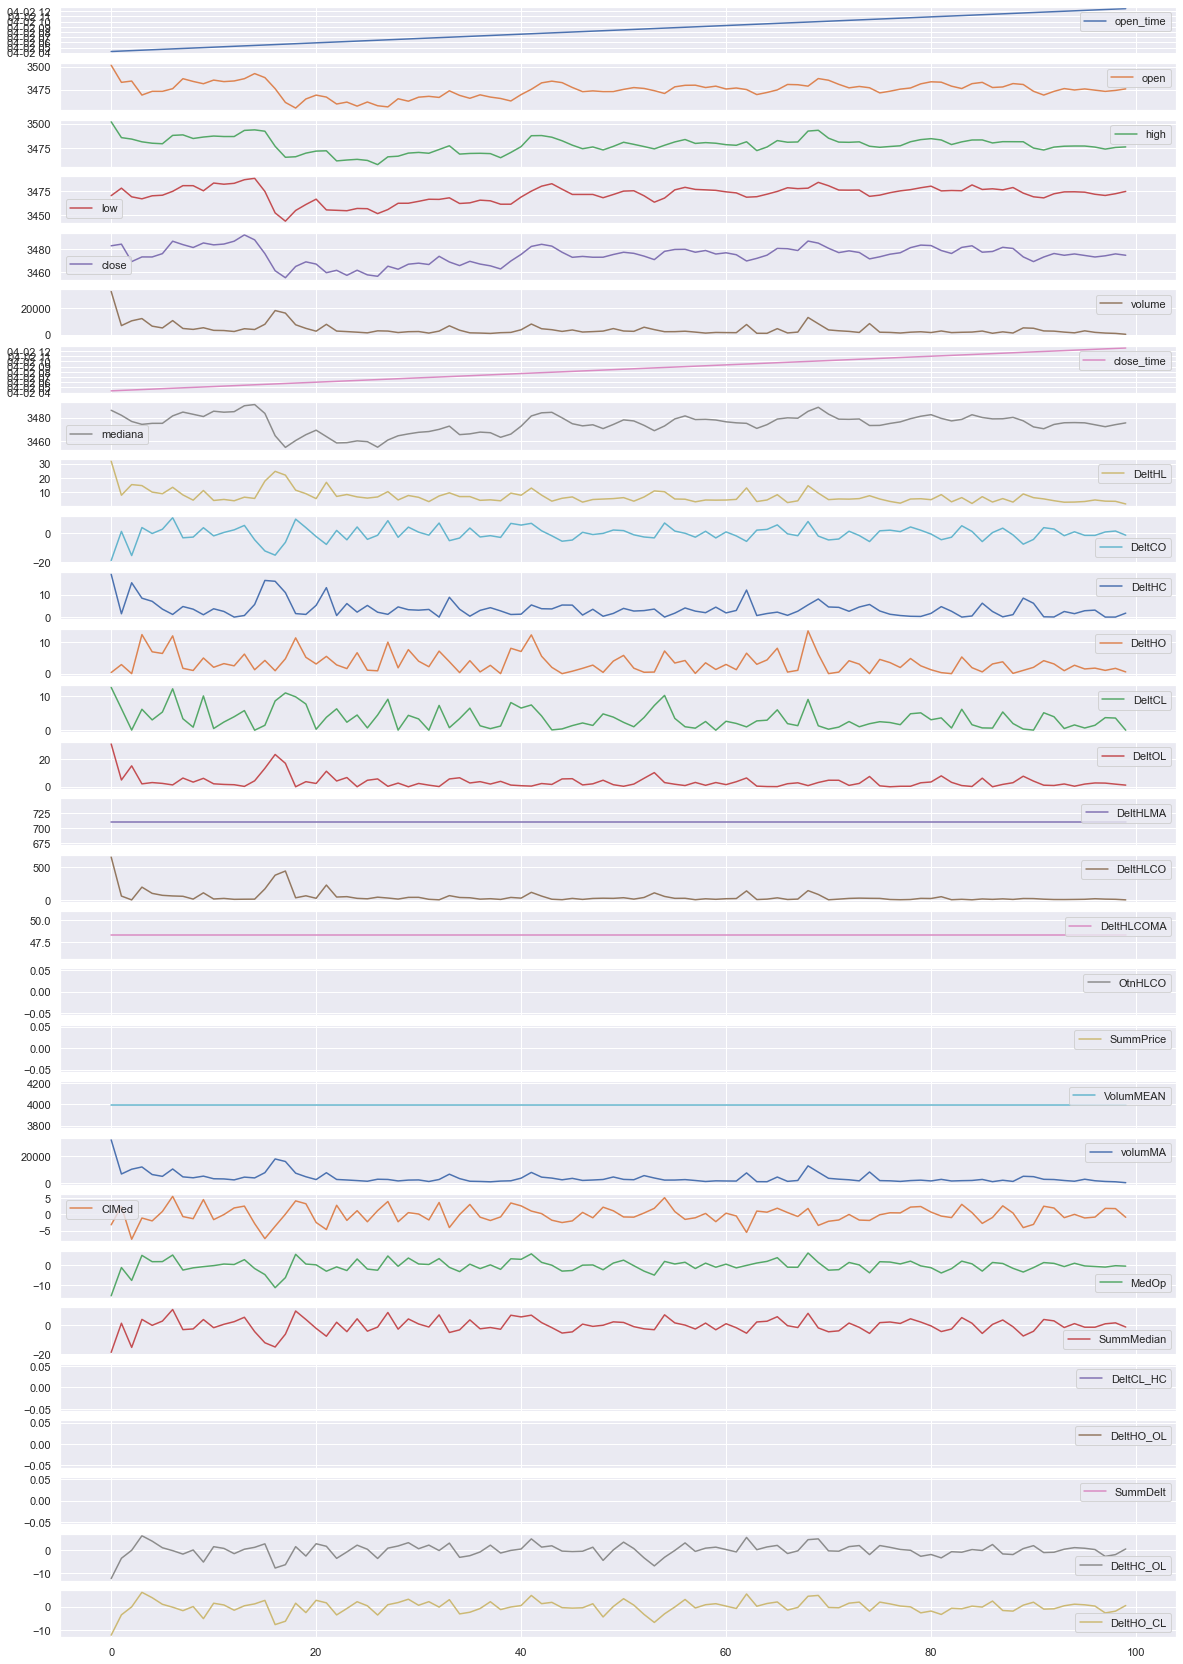

In [38]:
df.plot(subplots=True,figsize=(20,30))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 0 to 32
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   open_time   33 non-null     object 
 1   open        33 non-null     object 
 2   high        32 non-null     object 
 3   low         32 non-null     object 
 4   close       33 non-null     object 
 5   volume      33 non-null     object 
 6   close_time  33 non-null     object 
 7   mediana     32 non-null     object 
 8   DeltHL      30 non-null     float64
 9   DeltCO      31 non-null     float64
 10  DeltHC      30 non-null     float64
 11  DeltHO      30 non-null     float64
 12  DeltCL      30 non-null     float64
 13  DeltOL      30 non-null     float64
 14  DeltHLMA    33 non-null     float64
 15  DeltHLCO    30 non-null     float64
 16  DeltHLCOMA  33 non-null     float64
 17  OtnHLCO     0 non-null      object 
 18  SummPrice   0 non-null      object 
 19  VolumMEAN   33 non-null     flo

<AxesSubplot:>

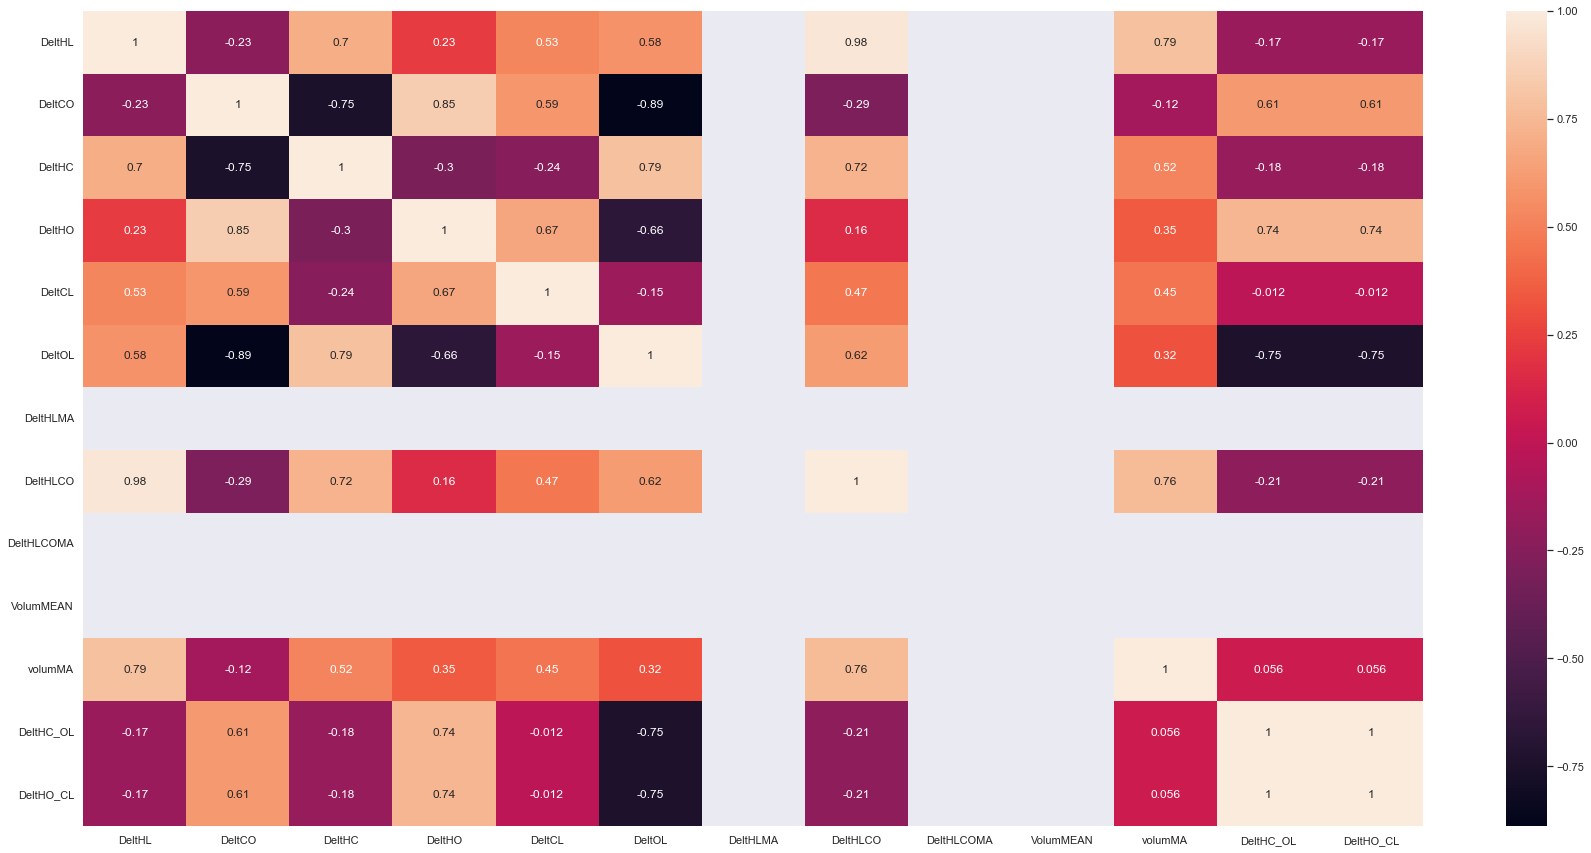

In [28]:
corr=df.corr()
sns.set(rc = {'figure.figsize':(30,15)})
sns.heatmap(corr,annot=True)

array([[<AxesSubplot:title={'center':'open_time'}>,
        <AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'high'}>,
        <AxesSubplot:title={'center':'low'}>,
        <AxesSubplot:title={'center':'close'}>],
       [<AxesSubplot:title={'center':'volume'}>,
        <AxesSubplot:title={'center':'close_time'}>,
        <AxesSubplot:title={'center':'mediana'}>,
        <AxesSubplot:title={'center':'DeltHL'}>,
        <AxesSubplot:title={'center':'DeltCO'}>],
       [<AxesSubplot:title={'center':'DeltHC'}>,
        <AxesSubplot:title={'center':'DeltHO'}>,
        <AxesSubplot:title={'center':'DeltCL'}>,
        <AxesSubplot:title={'center':'DeltOL'}>,
        <AxesSubplot:title={'center':'DeltHLMA'}>],
       [<AxesSubplot:title={'center':'DeltHLCO'}>,
        <AxesSubplot:title={'center':'DeltHLCOMA'}>,
        <AxesSubplot:title={'center':'VolumMEAN'}>,
        <AxesSubplot:title={'center':'volumMA'}>,
        <AxesSubplot:title={'center':'ClMed'}>],
     

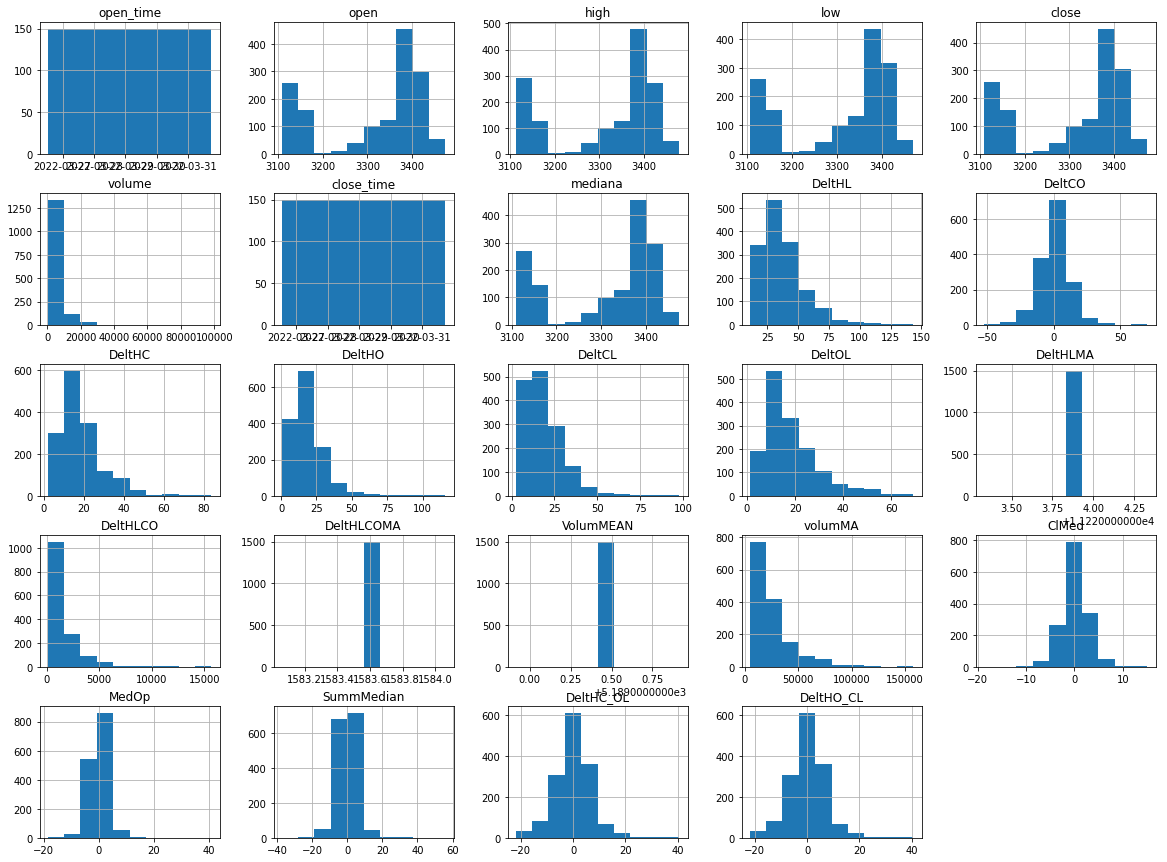

In [25]:
df.hist(figsize=(20,15))

array([[<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'high'}>,
        <AxesSubplot:title={'center':'low'}>,
        <AxesSubplot:title={'center':'close'}>,
        <AxesSubplot:title={'center':'volume'}>],
       [<AxesSubplot:title={'center':'mediana'}>,
        <AxesSubplot:title={'center':'DeltHL'}>,
        <AxesSubplot:title={'center':'DeltCO'}>,
        <AxesSubplot:title={'center':'DeltHC'}>,
        <AxesSubplot:title={'center':'DeltHO'}>],
       [<AxesSubplot:title={'center':'DeltCL'}>,
        <AxesSubplot:title={'center':'DeltOL'}>,
        <AxesSubplot:title={'center':'DeltHLMA'}>,
        <AxesSubplot:title={'center':'DeltHLCO'}>,
        <AxesSubplot:title={'center':'DeltHLCOMA'}>],
       [<AxesSubplot:title={'center':'VolumMEAN'}>,
        <AxesSubplot:title={'center':'volumMA'}>,
        <AxesSubplot:title={'center':'ClMed'}>,
        <AxesSubplot:title={'center':'MedOp'}>,
        <AxesSubplot:title={'center':'SummMedian'}>],
       [<

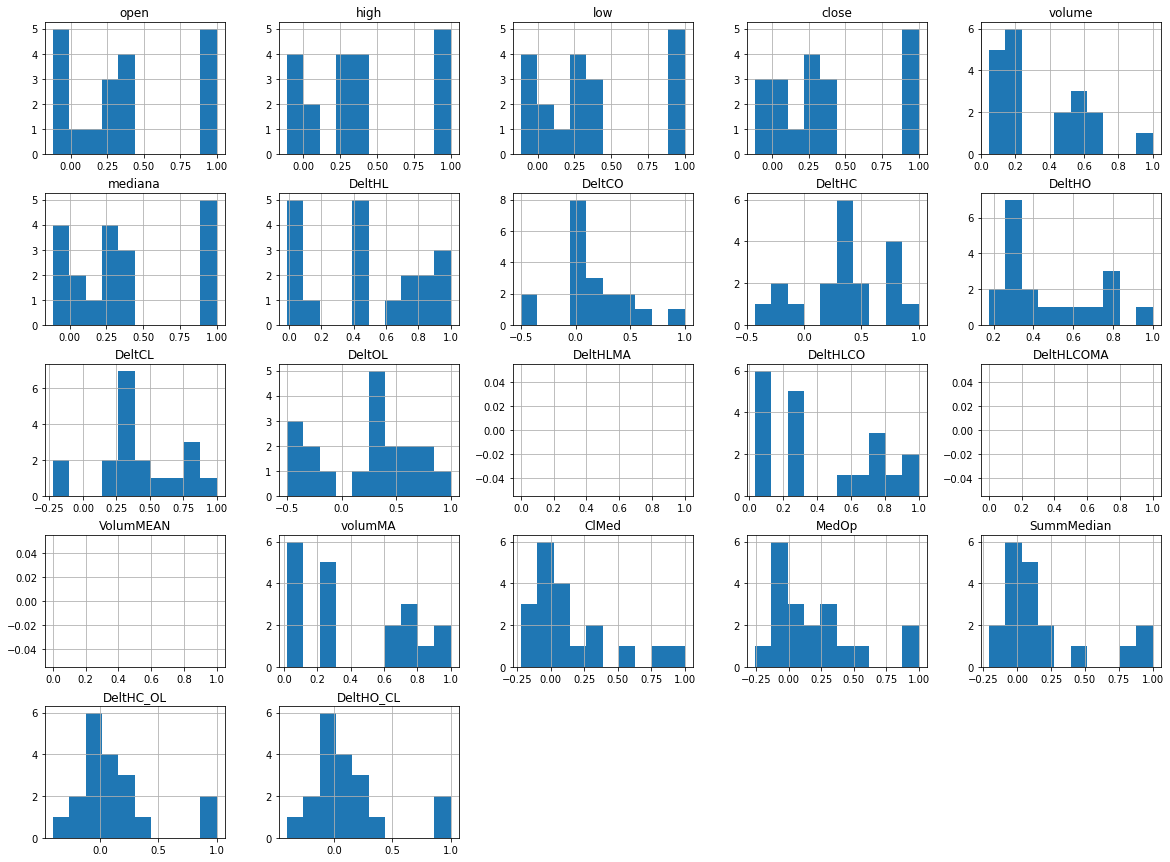

In [29]:
corr.hist(figsize=(20,15))

In [33]:
scaler=StandardScaler()
df2T=scaler.fit_transform(df)

KM=KMeans(n_clusters=10,  init='k-means++', n_init=10, max_iter=300, tol=0.0001, 
          verbose=0, random_state=None, copy_x=True, algorithm='auto')
AC=AgglomerativeClustering(n_clusters=10,  affinity='euclidean', memory=None, 
                           connectivity=None, compute_full_tree='auto', linkage='ward',
                           distance_threshold=None, compute_distances=False)

DB=DBSCAN(eps=0.5, min_samples=50, metric='euclidean', metric_params=None,
          algorithm='auto', leaf_size=30, p=None, n_jobs=None)

AP=AffinityPropagation( damping=0.5, max_iter=200, convergence_iter=15,
                    copy=True, preference=None, affinity='euclidean', verbose=False, random_state=None)

df3=df2
df3['clasKMeans']=KM.fit_predict(df2T)
df3['clasAC']=AC.fit_predict(df2T)
df3['clasDB']=DB.fit_predict(df2T)
df3['clasAP']=AP.fit_predict(df2T)

df3['clasKMeans1']=KM.fit_predict(df2)
df3['clasAC1']=AC.fit_predict(df2)
df3['clasDB1']=DB.fit_predict(df2)
df3['clasAP1']=AP.fit_predict(df2)


TypeError: float() argument must be a string or a real number, not 'Timestamp'

In [ ]:
df3

# график



In [ ]:
dm=round(df,2)
dm.describe()
chart(df.tail(500))

# Перезапуск таблицы символов и обновление инфы об ордерах

In [42]:
#ПЕРЕЗАПУСК и СБРОС информации о инструментах

GpathIm ='/content/drive/MyDrive/images/'
GpathH='/content/drive/MyDrive/history/'
Gpath='/content/drive/MyDrive/Bot/'
pathH='history/'
pathI='images/'
path0=''

GC=0
if GC==1:
    Im=GpathIm
    Hist=GpathH
    path=Gpath
else:
    Im=pathI
    Hist=pathH
    path=path0


tk=pd.read_csv(path+'symbFuture.csv',delimiter=';')
tks=pd.concat([tk, pd.DataFrame(columns = ['1mdCO', '1mdHC','SumD1m','DeltD1m','MeanSumD1m','5mdCO','5mdHC','15mdCO',
                                           '1hdCO','1hdHC','4hdCO' '4hdHC','1ddCO','1ddHC','1wdCO','1wdHC','deltaVol','time'])])
tks[['1mdCO', '1mdHC','SumD1m','DeltD1m','MeanSumD1m','5mdCO','5mdHC','15mdCO',
     '1hdCO','1hdHC','4hdCO' '4hdHC','1ddCO','1ddHC','1wdCO','1wdHC','deltaVol','time']] = 0.0


tks.to_csv(path+'SignalsymbFuture.csv')

ord=pd.concat([tk, pd.DataFrame(columns = ['Signal','SignalTime', 'SignalPrice','Order','OrderTime',
                                           'OrderPrice','FinRez','FinRezTime'])])
ord[['Signal', 'SignalPrice','Order','OrderPrice','FinRez','MaxFinRez']] = 0.0

Testord=pd.concat([tk, pd.DataFrame(columns = ['Signal','SignalTime', 'SignalPrice','Order','OrderTime',
                                           'OrderPrice','FinRez','FinRezTime'])])
Testord[['Signal', 'SignalPrice','Order','OrderPrice','FinRez','MaxFinRez']] = 0.0

In [ ]:
KEY = "GXEYu08wZKrzKGVrwLAWaLAzgDJ6S4qVJFD8oZrnCPAhItjWuK7l7P5CtNHUV3Sc"
SECRET = "vJdOG3Pboi6EEeTOmLqiT2yosM7OELDa590CXodd4fdCJj8uvF8paNGsI871Zhpj"

In [ ]:
#tks=tks.sort_values('SumD1m').reset_index(drop=True)

In [ ]:
import hmac
import time
import hashlib
import requests
import json
from urllib.parse import urlencode
#from cred import KEY, SECRET



# BASE_URL = 'https://fapi.binance.com' # production base url
BASE_URL = 'https://fapi.binance.com' # testnet base url

''' ======  begin of functions, you don't need to touch ====== '''
def hashing(query_string):
    return hmac.new(SECRET.encode('utf-8'), query_string.encode('utf-8'), hashlib.sha256).hexdigest()

def get_timestamp():
    return int(time.time() * 1000)

def dispatch_request(http_method):
    session = requests.Session()
    session.headers.update({
        'Content-Type': 'application/json;charset=utf-8',
        'X-MBX-APIKEY': KEY
    })
    return {
        'GET': session.get,
        'DELETE': session.delete,
        'PUT': session.put,
        'POST': session.post,
    }.get(http_method, 'GET')

# used for sending request requires the signature
def send_signed_request(http_method, url_path, payload={}):
#    print('base=',BASE_URL)
    query_string = urlencode(payload)
    # replace single quote to double quote
    query_string = query_string.replace('%27', '%22')
    if query_string:
        query_string = "{}&timestamp={}".format(query_string, get_timestamp())
    else:
        query_string = 'timestamp={}'.format(get_timestamp())

    url = BASE_URL + url_path + '?' + query_string + '&signature=' + hashing(query_string)
#    print("{} {}".format(http_method, url))
    params = {'url': url, 'params': {}}
    response = dispatch_request(http_method)(**params)
    return response.json()

# used for sending public data request
def send_public_request(url_path, payload={}):
    query_string = urlencode(payload, True)
    url = BASE_URL + url_path
    if query_string:
        url = url + '?' + query_string
    print("{}".format(url))
    response = dispatch_request('GET')(url=url)
    return response.json()

''' ======  end of functions ====== '''

# ОСНОВНОЕ проверка и торговля


In [53]:
#@title Результат работы { vertical-output: true }

fsymb = "" #@param [""]
#N NEW 27.02.2022
#                         ОСНОВНОЕ ПРОВЕРКА И ТОРГОВЛЯ
#

wposition =widgets.Textarea(disabled=True)
wsymb =widgets.Text(disabled=True)
wprofit=widgets.Text(disabled=True)
ww=widgets.Textarea(disabled=True)
display(wprofit)
display(wsymb,ww)
display(wposition)

while True:
    Fsymbol = 12 #@param {type:"slider", min:0, max:123, step:1}
    for sy in tks.loc[:].index:
        if sy%20==0:
            wposition.value=reducir()
          
        
        status = client.futures_account()
        positions=pd.DataFrame(status['positions'])     
        vhod1h=0
        vhod15m=0
        vhod4h=0     
        symb=tks.symbol[sy]
        wsymb.value=('              '+ symb+'                        '+str(time.ctime()))
        order = positions[positions['symbol']==symb]['positionAmt'].astype(float).tolist()[0]
        finrez=positions[positions['symbol']==symb]['unrealizedProfit'].astype(float).tolist()[0]
        notional = abs(positions[positions['symbol']==symb]['notional'].astype(float).tolist()[0])
        ord.at[sy,'OrderPrice']  = positions[positions['symbol']==symb]['entryPrice']
        profit = float(status['totalUnrealizedProfit'])
        balance = round(float(status['totalWalletBalance']),2)
        ord.at[sy,'OrderPrice']  = positions[positions['symbol']==symb]['entryPrice']
        ord.at[sy,'Order'] = order
        ord.at[sy,'FinRez'] = finrez   
        wprofit.value=(' profit= '+str(profit)+'  balance= '+str(balance))     
        timefr='1m'       
        #analiz
        try:

            dff=get_futures_klines(symb,timefr,500)

        except:
            print('Исключение')
            time.sleep(5)
            try:

                dff=get_futures_klines(symb,timefr,500)

            except:
                print('Исключение')
                time.sleep(10)
                dff=get_futures_klines(symb,timefr,500)
        i=[1,2,3]
        

        for n in i:
            if n==1:
                df1=dff
            else:
                df1=tfizm5(dff,n)

            df5=tfizm5(df1,5)

            df4h=0#podgData(tfizm5(df1,24))
            vhod4h=0#Signal(df4h,sy,-1)
            #SignalVh(df4h)
            
            df1h=podgData(tfizm5(df5,12),1)
            vhod1h=Signal(df1h,sy,-1)
            #SignalVh(df1h)

            df15m=podgData(tfizm5(df5,3),2)
            vhod15m=Signal(df15m,sy,-1)
            #SignalVh(df1h)

            df22= podgData(df1,5)
            vhod= Signal(df22,sy,-1)
            sigvh1=0#SignalVh(df1)

            df=podgData(df5,3)
            #zapisHistory(df,timefr,symb)
            vhod5m=Signal(df,sy,-1)
            sigvh=0#SignalVh(df)
            


            ww.value=(' vhod '+str(vhod)+' 4*vhod '+str(vhod5m)+' 12*vhod '+str(vhod15m)+' 48*vhod '+str(vhod1h) )           
                       
           
            i=-1
            
            if vhod5m>0 and ord.at[sy,'Order']==0  and vhod15m==1 and vhod1h!=-1  and vhod==1 :
                open_position(symb,'long',2*abs(float(tks.at[sy,'minOrd'])))
                ord.at[sy,'Order']=2*float(tks.at[sy,'minOrd'])
                ord.at[sy,'OrderTime']=str(time.ctime())
                print(symb+' Зашли BUY '+str(get_symbol_price(symb))+' Order= '+str(ord.at[sy,'Order'])+'  Signal= '+ str(ord.at[sy,'Signal'])+str(time.ctime()))
                print(symb+str(n)+' vhod '+str(vhod)+' 4*vhod '+str(vhod5m)+' 12*vhod '+str(vhod15m)+' 48*vhod'+str(vhod1h)) 
                #sendImage(symb+timefr)
                              
            elif vhod5m<0 and ord.at[sy,'Order']==0 and vhod15m==-1 and vhod1h!=1  and vhod==-1 :
                open_position(symb,'short',2*abs(float(tks.at[sy,'minOrd'])))
                ord.at[sy,'Order']=-2*float(tks.at[sy,'minOrd'])
                ord.at[sy,'OrderTime']=str(time.ctime()) 
                print('              '+symb+' Зашли SELL '+str(get_symbol_price(symb))+' Order= '+str(ord.at[sy,'Order'])+'  Signal= '+ str(ord.at[sy,'Signal'])+str(time.ctime()))
                print(symb+str(n)+' vhod '+str(vhod)+' 4*vhod '+str(vhod5m)+' 12*vhod '+str(vhod15m)+' 48*vhod'+str(vhod1h)) 
                #sendImage(symb+timefr)

                
            elif vhod<0 and ord.at[sy,'Order']>0  and vhod5m==-1   :
                open_position(symb,'short',abs(float(ord.at[sy,'Order'])))
                ord.at[sy,'Order']=0
                ord.at[sy,'OrderTime']=str(time.ctime())                 
                print(symb+' Выходим из лонга на М5 флэт '+str(get_symbol_price(symb))+'  Order= '+str(ord.at[sy,'Order'])+'  Signal= '+ str(ord.at[sy,'Signal'])+str(time.ctime()))
                print(symb+str(n)+' vhod '+str(vhod)+' 4*vhod '+str(vhod5m)+' 12*vhod '+str(vhod15m)+' 48*vhod'+str(vhod1h)) 
            elif vhod>0 and ord.at[sy,'Order']<0  and vhod5m==1   :
                open_position(symb,'long',abs(float(ord.at[sy,'Order'])))
                ord.at[sy,'Order']=0
                ord.at[sy,'OrderTime']=str(time.ctime())
                print(symb+' Выходим из шорта на М5 флэт  '+str(get_symbol_price(symb))+'  Order= '+str(ord.at[sy,'Order'])+'  Signal= '+ str(ord.at[sy,'Signal'])+str(time.ctime()))
                print(symb+str(n)+' vhod '+str(vhod)+' 4*vhod '+str(vhod5m)+' 12*vhod '+str(vhod15m)+' 48*vhod'+str(vhod1h)) 

            elif vhod5m<0 and ord.at[sy,'Order']>0 and (vhod15m==-1 and vhod1h!=1) and vhod==-1  :
                open_position(symb,'short',abs(float(order)))
                ord.at[sy,'Order']=0#-float(ord.at[sy,'Order'])
                ord.at[sy,'OrderTime']=str(time.ctime())  
                print('              '+symb+' Перевернулись в SELL '+str(get_symbol_price(symb))+'  Order= '+str(ord.at[sy,'Order'])+'  Signal= '+ str(ord.at[sy,'Signal']))                    
                print(str(time.ctime()))
                print(symb+str(n)+' vhod '+str(vhod)+' 4*vhod '+str(vhod5m)+' 12*vhod '+str(vhod15m)+' 48*vhod'+str(vhod1h)) 
                #sendImage(symb+timefr)
               
            elif vhod5m>0 and ord.at[sy,'Order']<0 and (vhod15m==1 and vhod1h!=-1) and vhod==1:
                open_position(symb,'long',abs(float(order)))
                ord.at[sy,'Order']=0#abs(float(ord.at[sy,'Order']))
                ord.at[sy,'OrderTime']=str(time.ctime()) 
                print(symb+' Перевернулись в BUY '+str(get_symbol_price(symb))+'  Order= '+str(ord.at[sy,'Order'])+'  Signal= '+ str(ord.at[sy,'Signal']))                   
                print(str(time.ctime()))
                print(symb+str(n)+' vhod '+str(vhod)+' 4*vhod '+str(vhod5m)+' 12*vhod '+str(vhod15m)+' 48*vhod'+str(vhod1h)) 
                #sendImage(symb+timefr)                    
                   
        #tks.at[sy,'Sum']=sum(tks.loc[sy][1:-1]) 
        tks.to_csv(path+'SignalsymbFuture.csv')
        ord.to_csv(path+'OrdersFutures.csv')
          

Text(value='', disabled=True)

Text(value='', disabled=True)

Textarea(value='', disabled=True)

Textarea(value='', disabled=True)

              COTIUSDT Зашли SELL 0.2839 Order= -80.0  Signal= -1.0Sat Apr  2 18:22:46 2022
COTIUSDT2 vhod -1 4*vhod -1 12*vhod -1 48*vhod0
              IOSTUSDT Зашли SELL 0.04022 Order= -800.0  Signal= -1.0Sat Apr  2 18:24:10 2022
IOSTUSDT2 vhod -1 4*vhod -1 12*vhod -1 48*vhod0
              ROSEUSDT Зашли SELL 0.27701 Order= -80.0  Signal= -1.0Sat Apr  2 18:25:45 2022
ROSEUSDT1 vhod -1 4*vhod -1 12*vhod -1 48*vhod0
              ADAUSDT Зашли SELL 1.172 Order= -20.0  Signal= -1.0Sat Apr  2 18:27:21 2022
ADAUSDT1 vhod -1 4*vhod -1 12*vhod -1 48*vhod-1
              COMPUSDT Зашли SELL 152.3 Order= -0.16  Signal= -1.0Sat Apr  2 18:28:35 2022
COMPUSDT1 vhod -1 4*vhod -1 12*vhod -1 48*vhod0
              OMGUSDT Зашли SELL 5.861 Order= -8.0  Signal= -1.0Sat Apr  2 18:31:06 2022
OMGUSDT2 vhod -1 4*vhod -1 12*vhod -1 48*vhod-1
              PEOPLEUSDT Зашли SELL 0.0705 Order= -320.0  Signal= -1.0Sat Apr  2 18:31:17 2022
PEOPLEUSDT2 vhod -1 4*vhod -1 12*vhod -1 48*vhod0
              ROSE

              PEOPLEUSDT Зашли SELL 0.0691 Order= -320.0  Signal= -1.0Sat Apr  2 18:55:25 2022
PEOPLEUSDT3 vhod -1 4*vhod -1 12*vhod -1 48*vhod0
              RENUSDT Зашли SELL 0.4715 Order= -60.0  Signal= -1.0Sat Apr  2 18:55:38 2022
RENUSDT3 vhod -1 4*vhod -1 12*vhod -1 48*vhod-1
              ROSEUSDT Зашли SELL 0.27476 Order= -80.0  Signal= -1.0Sat Apr  2 18:55:46 2022
ROSEUSDT3 vhod -1 4*vhod -1 12*vhod -1 48*vhod-1
              SANDUSDT Зашли SELL 3.5332 Order= -8.0  Signal= -1.0Sat Apr  2 18:55:56 2022
SANDUSDT2 vhod -1 4*vhod -1 12*vhod -1 48*vhod0
              SXPUSDT Зашли SELL 1.609 Order= -16.0  Signal= -1.0Sat Apr  2 18:56:22 2022
SXPUSDT3 vhod -1 4*vhod -1 12*vhod -1 48*vhod-1
              TRXUSDT Зашли SELL 0.07369 Order= -400.0  Signal= -1.0Sat Apr  2 18:56:40 2022
TRXUSDT1 vhod -1 4*vhod -1 12*vhod -1 48*vhod0
              VETUSDT Зашли SELL 0.07882 Order= -400.0  Signal= -1.0Sat Apr  2 18:56:52 2022
VETUSDT3 vhod -1 4*vhod -1 12*vhod -1 48*vhod0
              WAV

KeyboardInterrupt: 

In [16]:
df15m

,open_time,open,high,low,close,volume,close_time,mediana,DeltHL,DeltCO,...,VolumMEAN,volumMA,ClMed,MedOp,SummMedian,DeltCL_HC,DeltHO_OL,SummDelt,DeltHC_OL,DeltHO_CL
0,2022-04-02 10:20:00,47.164,NaN,NaN,47.163,0,2022-04-02 08:59:59.999000,NaN,NaN,-0.001,...,162355.755,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-04-02 09:00:00,47.163,47.337,47.015,47.257,324711.51,2022-04-02 09:59:59.999000,47.176,0.322,0.094,...,162355.755,324711.51,0.081,0.013,0.094,NaN,NaN,NaN,-0.068,-0.068


In [ ]:
#@title
var = 2 #@param {type:"integer"}
#  ISHODNOE
#                         ОСНОВНОЕ ПРОВЕРКА И ТОРГОВЛЯ
#
while True:
    for sy in tks.loc[:30].index:
        if sy%7==0:
          reducir()
          
        
        status = client.futures_account()
        positions=pd.DataFrame(status['positions'])     
        vhod1h=0
        vhod15m=0
        vhod4h=0     
        symb=tks.symbol[sy]
        print('              '+ symb+'                        '+str(time.ctime()))
        order = positions[positions['symbol']==symb]['positionAmt'].astype(float).tolist()[0]
        finrez=positions[positions['symbol']==symb]['unrealizedProfit'].astype(float).tolist()[0]
        notional = abs(positions[positions['symbol']==symb]['notional'].astype(float).tolist()[0])
        ord.at[sy,'OrderPrice']  = positions[positions['symbol']==symb]['entryPrice']
        profit = float(status['totalUnrealizedProfit'])
        balance = round(float(status['totalWalletBalance']),2)
        ord.at[sy,'OrderPrice']  = positions[positions['symbol']==symb]['entryPrice']
        ord.at[sy,'Order'] = order
        ord.at[sy,'FinRez'] = finrez   
        print(' profit= '+str(profit)+'  balance= '+str(balance))     
        timefr='5m'        
        #analiz
        if  timefr=='5m':
            
            df1=get_futures_klines(symb,timefr,1500)
            df5=tfizm5(df1,5)

            df4h=podgData(tfizm5(df5,48))
            vhod4h=Signal(df4h,sy,-1)
            #SignalVh(df4h)
            
            df1h=podgData(tfizm5(df5,12))
            vhod1h=Signal(df1h,sy,-1)
            #SignalVh(df1h)

            df15m=podgData(tfizm5(df5,3))
            vhod15m=Signal(df15m,sy,-1)
            #SignalVh(df1h)
            df1= podgData(df1)
            vhod= Signal(df1,sy,-1)
            sigvh1=0#SignalVh(df1)

            df=podgData(df5)
            zapisHistory(df,timefr,symb)
            vhod5m=Signal(df,sy,-1)
            sigvh=0#SignalVh(df)
            


            print(sigvh,sigvh1,vhod,vhod5m,vhod15m,vhod1h,vhod4h)            
            i=-1
            
            if ord.at[sy,'Signal']>0 and ord.at[sy,'Order']==0  and vhod15m!=-1 and vhod1h!=-1:
              open_position(symb,'long',2*abs(float(tks.at[sy,'minOrd'])))
              ord.at[sy,'Order']=2*float(tks.at[sy,'minOrd'])
              ord.at[sy,'OrderTime']=str(time.ctime())
              print(symb+' Зашли BUY '+str(get_symbol_price(symb))+' Order= '+str(ord.at[sy,'Order'])+'  Signal= '+ str(ord.at[sy,'Signal'])+str(time.ctime()))
              chartTel(df.tail(100),symb+timefr,'  Зашли BUY ')
              sendImage(symb+timefr)
                              
            elif ord.at[sy,'Signal']<0 and ord.at[sy,'Order']==0 and sigvh==1 and vhod15m!=1 and vhod1h!=1:
              open_position(symb,'short',2*abs(float(tks.at[sy,'minOrd'])))
              ord.at[sy,'Order']=-2*float(tks.at[sy,'minOrd'])
              ord.at[sy,'OrderTime']=str(time.ctime()) 
              print('                                                  '+symb+' Зашли SELL '+str(get_symbol_price(symb))+' Order= '+str(ord.at[sy,'Order'])+'  Signal= '+ str(ord.at[sy,'Signal'])+str(time.ctime()))
              chartTel(df.tail(100),symb+timefr,'  Зашли SELL ')
              sendImage(symb+timefr)


            elif ord.at[sy,'Signal']==0 and ord.at[sy,'Order']>0 and (vhod15m==-1 or vhod1h==-1 ) :
              open_position(symb,'short',abs(float(ord.at[sy,'Order'])))
              ord.at[sy,'Order']=0
              ord.at[sy,'OrderTime']=str(time.ctime())                 
              print(symb+' Выходим из лонга на М5 флэт '+str(get_symbol_price(symb))+'  Order= '+str(ord.at[sy,'Order'])+'  Signal= '+ str(ord.at[sy,'Signal'])+str(time.ctime()))
               
            elif ord.at[sy,'Signal']==0 and ord.at[sy,'Order']<0 and (vhod15m==1 or vhod1h==1 ) :
              open_position(symb,'long',abs(float(ord.at[sy,'Order'])))
              ord.at[sy,'Order']=0
              ord.at[sy,'OrderTime']=str(time.ctime())
              print(symb+' Выходим из шорта на М5 флэт  '+str(get_symbol_price(symb))+'  Order= '+str(ord.at[sy,'Order'])+'  Signal= '+ str(ord.at[sy,'Signal'])+str(time.ctime()))


            elif ord.at[sy,'Signal']<0 and ord.at[sy,'Order']>0 and (vhod15m!=1 and vhod1h!=1) :
              open_position(symb,'short',abs(2*float(ord.at[sy,'Order'])))
              ord.at[sy,'Order']=-float(ord.at[sy,'Order'])
              ord.at[sy,'OrderTime']=str(time.ctime())  
              print('              '+symb+' Перевернулись в SELL '+str(get_symbol_price(symb))+'  Order= '+str(ord.at[sy,'Order'])+'  Signal= '+ str(ord.at[sy,'Signal']))                    
              print(str(time.ctime()))
              chartTel(df.tail(100),symb+timefr,'  Перевернулись в SELL ')
              sendImage(symb+timefr)
               
            elif ord.at[sy,'Signal']>0 and ord.at[sy,'Order']<0 and (vhod15m!=-1 and vhod1h!=-1):
              open_position(symb,'long',abs(2*float(ord.at[sy,'Order'])))
              ord.at[sy,'Order']=abs(float(ord.at[sy,'Order']))
              ord.at[sy,'OrderTime']=str(time.ctime()) 
              print(symb+' Перевернулись в BUY '+str(get_symbol_price(symb))+'  Order= '+str(ord.at[sy,'Order'])+'  Signal= '+ str(ord.at[sy,'Signal']))                   
              print(str(time.ctime()))
              chartTel(df.tail(100),symb+timefr,'  Перевернулись в БАЙ ')
              sendImage(symb+timefr)                    
                   
        #tks.at[sy,'Sum']=sum(tks.loc[sy][1:-1]) 
        tks.to_csv(path+'SignalsymbFuture.csv')
        ord.to_csv(path+'OrdersFutures.csv')
          

# bactest History


In [ ]:
### HIstory Back test

def SignalTest(df,sy,i):

    s=0
    #if df.DeltCL[(df.index[i-1])]<df.DeltCL[(df.index[i])] and df.DeltOL[(df.index[i])]<df.DeltCL[(df.index[i])]:  
    #if df.DeltHC[(df.index[i])]<df.DeltCL[(df.index[i])]  and \
    #df.DeltOL[(df.index[i])]<df.DeltHO[(df.index[i])] and df.DeltOL[(df.index[i])]<df.DeltCL[(df.index[i])]\
    #and df.DeltHC[(df.index[i])]<df.DeltHO[(df.index[i])]and df.DeltHC[(df.index[i])]<df.DeltOL[(df.index[i])]:#\
    if df.DeltHO[(df.index[i])] > df.DeltHO[(df.index[i-1])] and df.DeltOL[(df.index[i])]<df.DeltOL[(df.index[i-1])] and df.DeltCL[(df.index[i])]>df.DeltHC[(df.index[i])]:
            ord.at[sy,'SignalTime']=df.open_time[(df.index[i])]  
            ord.at[sy,'Signal']=1
            s=1
            #print(symb+str(tks.at[sy,'deltaVol'])+ ' = DeltaVol   Signal= '+ str(ord.at[sy,'Signal'])+' Order= '+str(ord.at[sy,'Order']))
            #print(' ***покупаем на все ')
            #print(HLMA,HL2,HL1,HLCOMA,HLCO2,HLCO1)
            return (s)
    #elif  df.DeltHC[(df.index[i])]>df.DeltHO[(df.index[i])] and df.DeltHC[(df.index[i])]>df.DeltHC[(df.index[i-1])]:
    #elif  df.DeltHC[(df.index[i])]>df.DeltCL[(df.index[i])]  \
    #and df.DeltOL[(df.index[i])]>df.DeltHO[(df.index[i])] and df.DeltOL[(df.index[i])]>df.DeltCL[(df.index[i])]\
    #and df.DeltHC[(df.index[i])]>df.DeltHO[(df.index[i])] and df.DeltHC[(df.index[i])]>df.DeltOL[(df.index[i])]:
    if df.DeltHO[(df.index[i])] < df.DeltHO[(df.index[i-1])] and df.DeltOL[(df.index[i])]>df.DeltOL[(df.index[i-1])] and df.DeltCL[(df.index[i])]<df.DeltHC[(df.index[i])]:
            #tks.at[sy,timefr]=-2
            s=-1
            ord.at[sy,'Signal']=-1
            ord.at[sy,'SignalTime']=df.open_time[(df.index[i])]  
            #print('    продаем на все*** ')
            #print(HLMA,HL2,HL1,HLCOMA,HLCO2,HLCO1)
            return (s)
    else:
    #elif  df.DeltHC[(df.index[i])]>df.DeltCL[(df.index[i])] and df.DeltHO[(df.index[i])]>df.DeltOL[(df.index[i])] \
    #or df.DeltHC[(df.index[i])]<df.DeltCL[(df.index[i])] and df.DeltHO[(df.index[i])]<df.DeltOL[(df.index[i])]:
            #tks.at[sy,timefr]=0
            s=0
            ord.at[sy,'Signal']=0
            ord.at[sy,'SignalTime']=df.open_time[(df.index[i])]        
            #print(' Шляпа какая-то ')
            #print(HLMA,HL2,HL1,HLCOMA,HLCO2,HLCO1)
            return (s)
    ord.at[sy,'Signal']=0
    ord.at[sy,'SignalTime']=df.open_time[(df.index[i])] 
    #print(' Шляпа какая-то ')        
    return (s)

### HIstory Back test
def SignalTest1(df,sy,i):
    s=0  
    if df.DeltCO[(df.index[i])]>0  :#\
            Testord.at[sy,'SignalTime']=df.open_time[(df.index[i])]  
            Testord.at[sy,'Signal']=1
            #print(symb+str(tks.at[sy,'deltaVol'])+ ' = DeltaVol   Signal= '+ str(ord.at[sy,'Signal'])+' Order= '+str(ord.at[sy,'Order']))
            #print(' ***покупаем на все*** '+siga)
            s=1
            return s

    elif  df.DeltCO[(df.index[i])]<0 :
            Testord.at[sy,'Signal']=-1
            Testord.at[sy,'SignalTime']=df.open_time[(df.index[i])]  
            #print('                               ***продаем на все*** '+siga)
            s=-1
            return s
    else:# df.DeltHC[(df.index[i])]>df.DeltCL[(df.index[i])] and df.DeltHO[(df.index[i])]>df.DeltOL[(df.index[i])] \
    #or df.DeltHC[(df.index[i])]<df.DeltCL[(df.index[i])] and df.DeltHO[(df.index[i])]<df.DeltOL[(df.index[i])]:
            Testord.at[sy,'Signal']=0
            Testord.at[sy,'SignalTime']=df.open_time[(df.index[i])]        
            #print('                                                          Шляпа какая-то '+siga)
            return s
    Testord.at[sy,'Signal']=0
    return s
wprofit=widgets.Textarea()
ws=widgets.Textarea()
display(ws,wprofit)

Testord[['Signal', 'SignalPrice','Order','OrderPrice','FinRez','MaxFinRez']] = 0.0


t=0 
if t==0:#def backtest():
  rezult=0.0
  timefr='5m'
  
  nn=[0.1,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.60,0.7,0.8,0.9,1,1.5,2,2.5,3]
  n=0.4
  for sy in Testord.loc[:].index:#if n==0.2:#for n in nn:
    
    symb=Testord.symbol[sy]
    df777=get_futures_klines(symb,timefr,1500)
    
    df777=pd.concat([df777, pd.DataFrame(columns = ['sig1', 'sig4','sig12','sig48','sig96','vhod1','vhod4','vhod12','vhod48','vhod96','prsell','comiss','profit','otkrb', 'orkrs', 'zakr','perev','prib'])])
    ws.value=(tks.symbol[sy]+str(time.ctime()))
    profit=0.0
    prib=0
    zakr=0
    otkrb=0
    otkrs=0
    perev=0
    pribR=0
    pribL=0
    pribT=0
    i=-1 # по последней свече анализируем в индексе
    for n in df77.index:
         if n>370:
            dfukor=df77.loc[:n]

            df4=(tfizm5(dfukor,4))
            df4=podgData(df4)
            vhod4=SignalTest(df4,sy,i)
            sig4=SignalVh(df4)

            df12=podgData(tfizm5(dfukor,12))
            vhod12=SignalTest(df12,sy,i)
            sig12=SignalVh(df12)

            df48=podgData(tfizm5(dfukor,48))
            vhod48=SignalTest(df48,sy,i)
            sig48=SignalVh(df48)

            df96=podgData(tfizm5(dfukor,96))
            vhod96=SignalTest(df96,sy,i)
            sig96=SignalVh(df96)

            df=podgData(dfukor)
            vhod1=Signal(df,sy,i)
            sig1=SignalVh(df)
            #print(vhod4h,vhod1h,vhod15m,vhod5m)    
            
            prbuy= round(float(df.close[(df.index[i])])*abs(float(Testord.at[sy,'Order']))-(float(Testord.at[sy,'OrderPrice'])*abs(float(Testord.at[sy,'Order']))),2)
            prsell= round(float(Testord.at[sy,'OrderPrice'])*abs(float(Testord.at[sy,'Order']))-(float(df.close[(df.index[i])])*abs(float(Testord.at[sy,'Order']))),2)
            comiss=round(0.001*float(df.close[(df.index[i])])*abs(float(Testord.at[sy,'Order'])),2)
            
            #print(prbuy,prsell,comiss)
            if  Testord.at[sy,'Order']==0 and vhod1==1 and vhod4!=-1   and vhod12!=-1 and vhod48!=-1 and vhod96!=-1:
                Testord.at[sy,'Order']=2*float(Testord.at[sy,'minOrd'])
                Testord.at[sy,'OrderTime']=df.open_time[(df.index[i])]
                Testord.at[sy,'OrderPrice']=   df.close[(df.index[i])]
                #print(round(profit,2), Testord.at[sy,'OrderPrice'],Testord.at[sy,'OrderTime'])
                #print('зашли в лонг')
                otkrb+=1
            elif Testord.at[sy,'Order']==0  and vhod1==-1 and vhod4!=1   and vhod12!=1 and vhod48!=1 and vhod96!=1:
                Testord.at[sy,'Order']=-2*float(Testord.at[sy,'minOrd'])
                Testord.at[sy,'OrderTime']=df.open_time[(df.index[i])]
                Testord.at[sy,'OrderPrice']=df.close[(df.index[i])]
                #print(round(profit,2), Testord.at[sy,'OrderPrice'],Testord.at[sy,'OrderTime'])
                #print('зашли в шорт')
                otkrs+=1

            elif Testord.at[sy,'Order']>0 and (vhod1==-1):# or vhod4==-1 or vhod12==-1 or vhod48==-1 or vhod96==-1) :
                profit=profit+prbuy-comiss
                
                Testord.at[sy,'Order']=0
                Testord.at[sy,'OrderTime']=df.open_time[(df.index[i])]
                Testord.at[sy,'OrderPrice']=0  
                #print(round(profit,2),Testord.at[sy,'OrderTime'],prbuy)
                zakr+=1            
            elif Testord.at[sy,'Order']<0 and (vhod1==1):# or vhod4==1 or vhod12==1 or vhod48==1 or vhod96==1) :
                profit=profit+prsell-comiss
                
                Testord.at[sy,'Order']=0
                Testord.at[sy,'OrderTime']=df.open_time[(df.index[i])]
                Testord.at[sy,'OrderPrice']=0
                #print(round(profit,2),Testord.at[sy,'OrderTime'],prsell)
                zakr+=1 

            elif  Testord.at[sy,'Order']>0  and (vhod1!=1):# and vhod4!=1 and vhod12!=1 and vhod48!=1 and vhod96!=1):
                profit=profit+prbuy-comiss
                
                Testord.at[sy,'Order']=0#-float(Testord.at[sy,'Order'])
                Testord.at[sy,'OrderTime']=df.open_time[(df.index[i])]
                Testord.at[sy,'OrderPrice']=0#df.close[(df.index[i])]
                #print(round(profit,2),Testord.at[sy,'OrderTime'],Testord.at[sy,'Order'],prbuy)
                #print('закрыли лонг,сигнал в шорт')
                perev+=1
            elif Testord.at[sy,'Order']<0  and (vhod1!=-1):# and vhod4!=-1 and vhod12!=-1 and vhod48!=-1 and vhod96!=-1):
                profit=profit+prsell-comiss
                
                Testord.at[sy,'Order']=0#abs(float(Testord.at[sy,'Order']))
                Testord.at[sy,'OrderTime']=df.open_time[(df.index[i])]
                Testord.at[sy,'OrderPrice']=0#df.close[(df.index[i])]
                #print(round(profit,2),Testord.at[sy,'OrderTime'],Testord.at[sy,'Order'],prsell)
                #print('закрыли шорт сигнал в лонг')
                perev+=1   

            ### Reducir profit
            if Testord.at[sy,'Order']>0 and Testord.at[sy,'Order']==2*float(Testord.at[sy,'minOrd'])  and \
            (round(float(df.close[(df.index[i])])*abs(float(Testord.at[sy,'Order']))-(float(Testord.at[sy,'OrderPrice'])*abs(float(Testord.at[sy,'Order']))),2)>3 or\
             round(float(df.close[(df.index[i])])*abs(float(Testord.at[sy,'Order']))-(float(Testord.at[sy,'OrderPrice'])*abs(float(Testord.at[sy,'Order']))),2)<-1) :
                profit=profit+round(float(df.close[(df.index[i])])*abs(float(Testord.at[sy,'Order']))-(float(Testord.at[sy,'OrderPrice'])*abs(float(Testord.at[sy,'Order']))),2)*0.5-round(0.001*float(df.close[(df.index[i])])*abs(float(Testord.at[sy,'Order'])),2)*0.5
                Testord.at[sy,'Order']=Testord.at[sy,'Order']*0.5
                Testord.at[sy,'OrderTime']=df.open_time[(df.index[i])]
                #print(round(profit,2),Testord.at[sy,'OrderTime'],prbuy)
                #print('reducir profit long')
                pribR+=1 
            if Testord.at[sy,'Order']<0 and Testord.at[sy,'Order']==-2*float(Testord.at[sy,'minOrd']) and \
            (round(float(Testord.at[sy,'OrderPrice'])*abs(float(Testord.at[sy,'Order']))-(float(df.close[(df.index[i])])*abs(float(Testord.at[sy,'Order']))),2)>3 or\
             round(float(Testord.at[sy,'OrderPrice'])*abs(float(Testord.at[sy,'Order']))-(float(df.close[(df.index[i])])*abs(float(Testord.at[sy,'Order']))),2)<-1)  :
                profit=profit+round(float(Testord.at[sy,'OrderPrice'])*abs(float(Testord.at[sy,'Order']))-(float(df.close[(df.index[i])])*abs(float(Testord.at[sy,'Order']))),2)*0.5-round(0.001*float(df.close[(df.index[i])])*abs(float(Testord.at[sy,'Order'])),2)*0.5
                Testord.at[sy,'Order']=Testord.at[sy,'Order']*0.5
                Testord.at[sy,'OrderTime']=df.open_time[(df.index[i])]
                #print(round(profit,2),Testord.at[sy,'OrderTime'],prsell)
                #print('reducir profit short')
                pribR+=1 

            ### TAKE PROFIT
            if Testord.at[sy,'Order']>0 and \
            (round(float(df.close[(df.index[i])])*abs(float(Testord.at[sy,'Order']))-(float(Testord.at[sy,'OrderPrice'])*abs(float(Testord.at[sy,'Order']))),2)>6) :
                profit=profit+round(float(df.close[(df.index[i])])*abs(float(Testord.at[sy,'Order']))-(float(Testord.at[sy,'OrderPrice'])*abs(float(Testord.at[sy,'Order']))),2)-round(0.001*float(df.close[(df.index[i])])*abs(float(Testord.at[sy,'Order'])),2)
                Testord.at[sy,'Order']=0
                Testord.at[sy,'OrderTime']=df.open_time[(df.index[i])]
                Testord.at[sy,'OrderPrice']=0
                #print(round(profit,2),Testord.at[sy,'OrderTime'],prbuy)
                #print('TAKE PROFIT')
                pribT+=1 
            if Testord.at[sy,'Order']<0 and \
            (round(float(Testord.at[sy,'OrderPrice'])*abs(float(Testord.at[sy,'Order']))-(float(df.close[(df.index[i])])*abs(float(Testord.at[sy,'Order']))),2)>6)  :
                profit=profit+round(float(Testord.at[sy,'OrderPrice'])*abs(float(Testord.at[sy,'Order']))-(float(df.close[(df.index[i])])*abs(float(Testord.at[sy,'Order']))),2)-round(0.001*float(df.close[(df.index[i])])*abs(float(Testord.at[sy,'Order'])),2)
                Testord.at[sy,'Order']=0
                Testord.at[sy,'OrderTime']=df.open_time[(df.index[i])]
                Testord.at[sy,'OrderPrice']=0
                #print(round(profit,2),Testord.at[sy,'OrderTime'],prsell)
                #print('TAKE PROFIT')
                pribT+=1 

            ### STOP LOSS
            if Testord.at[sy,'Order']>0 and \
            (round(float(df.close[(df.index[i])])*abs(float(Testord.at[sy,'Order']))-(float(Testord.at[sy,'OrderPrice'])*abs(float(Testord.at[sy,'Order']))),2)<-3) :
                profit=profit+round(float(df.close[(df.index[i])])*abs(float(Testord.at[sy,'Order']))-(float(Testord.at[sy,'OrderPrice'])*abs(float(Testord.at[sy,'Order']))),2)-round(0.001*float(df.close[(df.index[i])])*abs(float(Testord.at[sy,'Order'])),2)
                Testord.at[sy,'Order']=0
                Testord.at[sy,'OrderTime']=df.open_time[(df.index[i])]
                Testord.at[sy,'OrderPrice']=0
                #print(round(profit,2),Testord.at[sy,'OrderTime'],prbuy)
                #print('STOP LOSS')
                pribL+=1 
            if Testord.at[sy,'Order']<0 and\
             (round(float(Testord.at[sy,'OrderPrice'])*abs(float(Testord.at[sy,'Order']))-(float(df.close[(df.index[i])])*abs(float(Testord.at[sy,'Order']))),2)<-3)  :
                profit=profit+round(float(Testord.at[sy,'OrderPrice'])*abs(float(Testord.at[sy,'Order']))-(float(df.close[(df.index[i])])*abs(float(Testord.at[sy,'Order']))),2)-round(0.001*float(df.close[(df.index[i])])*abs(float(Testord.at[sy,'Order'])),2)
                Testord.at[sy,'Order']=0
                Testord.at[sy,'OrderTime']=df.open_time[(df.index[i])]
                Testord.at[sy,'OrderPrice']=0
                #print(round(profit,2),Testord.at[sy,'OrderTime'],prsell)
                #print('STOP LOSS')
                pribL+=1                
            df777.at[n,'sig1']=sig1
            df777.at[n,'sig4']=sig4
            df777.at[n,'sig12']=sig12
            df777.at[n,'sig48']=sig48

            df777.at[n,'vhod1']=vhod1
            df777.at[n,'vhod4']=vhod4
            df777.at[n,'vhod12']=vhod12
            df777.at[n,'vhod48']=vhod48
            df777.at[n,'vhod96']=vhod96
            df777.at[n,'otkrb']=otkrb
            df777.at[n,'otkrs']=otkrs
            df777.at[n,'zakr']=zakr
            df777.at[n,'profit']=profit
            df777.at[n,'prib']=prib
            df777.at[n,'perev']=perev
            print(sig1,sig4,sig12,sig48,vhod1,vhod4,vhod12,vhod48,vhod96, df.close[(df.index[i])],df.open_time[(df.index[i])],round(profit,2), otkrb,otkrs,zakr,pribT,pribR,pribL,perev,prbuy,prsell)
            wprofit.value=str(profit)+'  '+str(prbuy)+'  '+str(prsell)

   
            #df[df.index==n] [ ['sig4h', 'sig1h','sigvh','s','vhod15m','vhod1h','prbuy','prsell','comiss','profit']]=[[sig4h, sig1h,sigvh,s,vhod15m,vhod1h,prbuy,prsell,comiss,profit]]  
            df777.to_csv(path+'BackTest'+symb+timefr+'сигнал COбольше или меньше нуля.csv')

    Testord.at[sy,'FinRez']=profit
    print(round(profit,2),otkrb,zakr,perev,prib,n)
     
    rezult=rezult+profit
    print(rezult)

In [ ]:
df

In [ ]:
df77

# backtest online

In [ ]:
# ONLINE TEST
def SignalTest(df,sy,i):
    s=0  
    if df.DeltCL[(df.index[i-1])]<df.DeltCL[(df.index[i])] and df.DeltOL[(df.index[i])]<df.DeltCL[(df.index[i])]  :#\
            Testord.at[sy,'SignalTime']=df.open_time[(df.index[i])]  
            Testord.at[sy,'Signal']=1
            #print(symb+str(tks.at[sy,'deltaVol'])+ ' = DeltaVol   Signal= '+ str(ord.at[sy,'Signal'])+' Order= '+str(ord.at[sy,'Order']))
            #print(' ***покупаем на все*** '+siga)
            s=1
            return s

    elif  df.DeltHC[(df.index[i])]>df.DeltHO[(df.index[i])] and df.DeltHC[(df.index[i])]>df.DeltHC[(df.index[i-1])] :
            Testord.at[sy,'Signal']=-1
            Testord.at[sy,'SignalTime']=df.open_time[(df.index[i])]  
            #print('                               ***продаем на все*** '+siga)
            s=-1
            return s
    else:# df.DeltHC[(df.index[i])]>df.DeltCL[(df.index[i])] and df.DeltHO[(df.index[i])]>df.DeltOL[(df.index[i])] \
    #or df.DeltHC[(df.index[i])]<df.DeltCL[(df.index[i])] and df.DeltHO[(df.index[i])]<df.DeltOL[(df.index[i])]:
            Testord.at[sy,'Signal']=0
            Testord.at[sy,'SignalTime']=df.open_time[(df.index[i])]        
            #print('                                                          Шляпа какая-то '+siga)
            return s
    Testord.at[sy,'Signal']=0
    return s



Testord[['Signal', 'SignalPrice','Order','OrderPrice','FinRez','MaxFinRez']] = 0.0
rezult=0.0
timefr='5m'

prib=0
zakr=0
otkr=0
perev=0
pribR=0
pribL=0
pribT=0
  #df=pd.read_csv(Hist+symb+timefr+'Obrabotka.csv')
profit=0.0
 
while True:
  

  nn=[0.1,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.60,0.7,0.8,0.9,1,1.5,2,2.5,3]
  n=0.2
  for sy in tks.loc[:].index:
    symb=tks.symbol[sy]
    df77=podgData(get_futures_klines(symb,timefr,350))
    df777=pd.concat([df77, pd.DataFrame(columns = ['sig4h', 'sig1h','sigvh','vhod5m','vhod15m','vhod1h','vhod4h','prsell','comiss','profit','otkr','zakr','perev','prib'])])
    prise=0
    print("    "+tks.symbol[sy])
    i=-1
    df5=df77 #tfizm5(df77,5)
    df4h=podgData(tfizm5(df5,48))
    vhod4h=SignalTest(df4h,sy,i)
    sig4h=SignalVh(df4h)
    
    df1h=podgData(tfizm5(df5,12))
    vhod1h=SignalTest(df1h,sy,i)
    sig1h=SignalVh(df1h)

    df15m=podgData(tfizm5(df5,3))
    vhod15m=SignalTest(df15m,sy,i)

    prise=float(df.close[(df.index[i])])#get_symbol_price(symb)
    #SignalVh(df1h)
    df=podgData(df5)
    #Signal(df,sy,i)
    sigvh=SignalVh(df)
    #print(vhod4h,vhod1h,vhod15m,vhod5m)    
    vhod5m=SignalTest(df,sy,i)

    prbuy= round(float(df.close[(df.index[i])])*abs(float(Testord.at[sy,'Order']))-(float(Testord.at[sy,'OrderPrice'])*abs(float(Testord.at[sy,'Order']))),2)
    prsell= round(float(Testord.at[sy,'OrderPrice'])*abs(float(Testord.at[sy,'Order']))-(float(df.close[(df.index[i])])*abs(float(Testord.at[sy,'Order']))),2)
    comiss=round(0.001*float(df.close[(df.index[i])])*abs(float(Testord.at[sy,'Order'])),2)

    if i==-1:
            if Testord.at[sy,'Signal']>0 and Testord.at[sy,'Order']==0 and sigvh==1  and vhod15m!=-1 and vhod1h!=-1:# and vhod4h!=-1:# and vhod15m>0 and vhod1h>0and vhod4h!=0 and sigvh==1  :
                Testord.at[sy,'Order']=2*float(Testord.at[sy,'minOrd'])
                Testord.at[sy,'OrderTime']=df.open_time[(df.index[i])]
                Testord.at[sy,'OrderPrice']=   prise
                #print(round(profit,2), Testord.at[sy,'OrderPrice'],Testord.at[sy,'OrderTime'])
                #print('зашли в лонг')
                otkr+=1
            elif Testord.at[sy,'Signal']<0 and Testord.at[sy,'Order']==0 and sigvh==1 and vhod15m!=1 and vhod1h!=1:# and vhod4h!=1:# and vhod15m>0 and vhod1h>0and vhod4h!=0 and sigvh==1:
                Testord.at[sy,'Order']=-2*float(Testord.at[sy,'minOrd'])
                Testord.at[sy,'OrderTime']=df.open_time[(df.index[i])]
                Testord.at[sy,'OrderPrice']=prise
                #print(round(profit,2), Testord.at[sy,'OrderPrice'],Testord.at[sy,'OrderTime'])
                #print('зашли в шорт')
                otkr+=1

            elif  Testord.at[sy,'Order']>0  :
                print(Testord.at[sy,'Order'],round((prise*abs(Testord.at[sy,'Order']))-(Testord.at[sy,'OrderPrice']*abs(Testord.at[sy,'Order'])),2)-round(0.001*prise*abs(float(Testord.at[sy,'Order'])),2))                
            elif  Testord.at[sy,'Order']<0  :
                print(Testord.at[sy,'Order'],round(-(prise*abs(Testord.at[sy,'Order']))+(Testord.at[sy,'OrderPrice']*abs(Testord.at[sy,'Order'])),2) -round(0.001*prise*abs(float(Testord.at[sy,'Order'])),2))                


            elif (Testord.at[sy,'Signal']==0 and Testord.at[sy,'Order']>0 and (vhod15m==-1 or vhod1h==-1 )) :# and (vhod15m==0 or vhod1h==0):
                profit=profit+round((prise*abs(Testord.at[sy,'Order']))-(Testord.at[sy,'OrderPrice']*abs(Testord.at[sy,'Order'])),2)-round(0.001*prise*abs(float(Testord.at[sy,'Order'])),2) 
                Testord.at[sy,'Order']=0
                Testord.at[sy,'OrderTime']=df.open_time[(df.index[i])]
                Testord.at[sy,'OrderPrice']=0  
                #print(round(profit,2),Testord.at[sy,'OrderTime'],prbuy)
                zakr+=1            
            elif Testord.at[sy,'Signal']==0 and Testord.at[sy,'Order']<0 and (vhod15m==1 or vhod1h==1) :#and (vhod15m==0 or vhod1h==0): 
                profit=profit+round(-(prise*abs(Testord.at[sy,'Order']))+(Testord.at[sy,'OrderPrice']*abs(Testord.at[sy,'Order'])),2) -round(0.001*prise*abs(float(Testord.at[sy,'Order'])),2)
                Testord.at[sy,'Order']=0
                Testord.at[sy,'OrderTime']=df.open_time[(df.index[i])]
                Testord.at[sy,'OrderPrice']=0
                #print(round(profit,2),Testord.at[sy,'OrderTime'],prsell)
                zakr+=1 

            elif Testord.at[sy,'Signal']<0 and Testord.at[sy,'Order']>0  and (vhod15m!=1 and vhod1h!=1):
                profit=profit+round((prise*abs(Testord.at[sy,'Order']))-(Testord.at[sy,'OrderPrice']*abs(Testord.at[sy,'Order'])),2)-round(0.001*prise*abs(float(Testord.at[sy,'Order'])),2) 
                Testord.at[sy,'Order']=0#-float(Testord.at[sy,'Order'])
                Testord.at[sy,'OrderTime']=df.open_time[(df.index[i])]
                Testord.at[sy,'OrderPrice']=0#df.close[(df.index[i])]
                #print(round(profit,2),Testord.at[sy,'OrderTime'],Testord.at[sy,'Order'],prbuy)
                #print('закрыли лонг,сигнал в шорт')
                perev+=1
            elif Testord.at[sy,'Signal']>0 and Testord.at[sy,'Order']<0  and (vhod15m!=-1 and vhod1h!=-1):
                profit=profit+round(-(prise*abs(Testord.at[sy,'Order']))+(Testord.at[sy,'OrderPrice']*abs(Testord.at[sy,'Order'])),2) -round(0.001*prise*abs(float(Testord.at[sy,'Order'])),2)
                Testord.at[sy,'Order']=0#abs(float(Testord.at[sy,'Order']))
                Testord.at[sy,'OrderTime']=df.open_time[(df.index[i])]
                Testord.at[sy,'OrderPrice']=0#df.close[(df.index[i])]
                #print(round(profit,2),Testord.at[sy,'OrderTime'],Testord.at[sy,'Order'],prsell)
                #print('закрыли шорт сигнал в лонг')
                perev+=1   

                  ### Reducir profit
            elif Testord.at[sy,'Order']>0 and Testord.at[sy,'Order']==2*float(Testord.at[sy,'minOrd'])  and \
               (round((prise*abs(Testord.at[sy,'Order']))-(Testord.at[sy,'OrderPrice']*abs(Testord.at[sy,'Order'])),2)>0.3 \
                or round((prise*abs(Testord.at[sy,'Order']))-(Testord.at[sy,'OrderPrice']*abs(Testord.at[sy,'Order'])),2)<-0.05) :
                profit=profit+round((prise*abs(Testord.at[sy,'Order']))-(Testord.at[sy,'OrderPrice']*abs(Testord.at[sy,'Order'])),2)*0.5-round(0.001*prise*abs(float(Testord.at[sy,'Order'])),2)*0.5 
                Testord.at[sy,'Order']=Testord.at[sy,'Order']*0.5
                Testord.at[sy,'OrderTime']=df.open_time[(df.index[i])]
                #print(round(profit,2),Testord.at[sy,'OrderTime'],prbuy)
                #print('reducir profit long')
                pribR+=1 
            elif Testord.at[sy,'Order']<0 and Testord.at[sy,'Order']==-2*float(Testord.at[sy,'minOrd']) and (round(-(prise*abs(Testord.at[sy,'Order']))+(Testord.at[sy,'OrderPrice']*abs(Testord.at[sy,'Order'])),2)>0.3 or round(-(prise*abs(Testord.at[sy,'Order']))+(Testord.at[sy,'OrderPrice']*abs(Testord.at[sy,'Order'])),2)<-0.05)  :
                profit=profit+round(-(prise*abs(Testord.at[sy,'Order']))+(Testord.at[sy,'OrderPrice']*abs(Testord.at[sy,'Order'])),2)*0.5 -round(0.001*prise*abs(float(Testord.at[sy,'Order'])),2)*0.5
                Testord.at[sy,'Order']=Testord.at[sy,'Order']*0.5
                Testord.at[sy,'OrderTime']=df.open_time[(df.index[i])]
                #print(round(profit,2),Testord.at[sy,'OrderTime'],prsell)
                #print('reducir profit short')
                pribR+=1 

                 ### TAKE PROFIT
            elif Testord.at[sy,'Order']>0 and (round((prise*abs(Testord.at[sy,'Order']))-(Testord.at[sy,'OrderPrice']*abs(Testord.at[sy,'Order'])),2)>1.3) :
                profit=profit+round((prise*abs(Testord.at[sy,'Order']))-(Testord.at[sy,'OrderPrice']*abs(Testord.at[sy,'Order'])),2)-round(0.001*prise*abs(float(Testord.at[sy,'Order'])),2) 
                Testord.at[sy,'Order']=0
                Testord.at[sy,'OrderTime']=df.open_time[(df.index[i])]
                Testord.at[sy,'OrderPrice']=0
                #print(round(profit,2),Testord.at[sy,'OrderTime'],prbuy)
                #print('TAKE PROFIT')
                pribT+=1 
            elif Testord.at[sy,'Order']<0 and (round(-(prise*abs(Testord.at[sy,'Order']))+(Testord.at[sy,'OrderPrice']*abs(Testord.at[sy,'Order'])),2)>1.3)  :
                profit=profit+round(-(prise*abs(Testord.at[sy,'Order']))+(Testord.at[sy,'OrderPrice']*abs(Testord.at[sy,'Order'])),2) -round(0.001*prise*abs(float(Testord.at[sy,'Order'])),2)
                Testord.at[sy,'Order']=0
                Testord.at[sy,'OrderTime']=df.open_time[(df.index[i])]
                Testord.at[sy,'OrderPrice']=0
                #print(round(profit,2),Testord.at[sy,'OrderTime'],prsell)
                #print('TAKE PROFIT')
                pribT+=1 

                 ### STOP LOSS
            elif Testord.at[sy,'Order']>0 and (round((prise*abs(Testord.at[sy,'Order']))-(Testord.at[sy,'OrderPrice']*abs(Testord.at[sy,'Order'])),2)<-0.5) :
                profit=profit+round((prise*abs(Testord.at[sy,'Order']))-(Testord.at[sy,'OrderPrice']*abs(Testord.at[sy,'Order'])),2)-round(0.001*prise*abs(float(Testord.at[sy,'Order'])),2) 
                Testord.at[sy,'Order']=0
                Testord.at[sy,'OrderTime']=df.open_time[(df.index[i])]
                Testord.at[sy,'OrderPrice']=0
                #print(round(profit,2),Testord.at[sy,'OrderTime'],prbuy)
                #print('STOP LOSS')
                pribL+=1 
            elif Testord.at[sy,'Order']<0 and (round(-(prise*abs(Testord.at[sy,'Order']))+(Testord.at[sy,'OrderPrice']*abs(Testord.at[sy,'Order'])),2)<-0.5)  :
                profit=profit+round(-(prise*abs(Testord.at[sy,'Order']))+(Testord.at[sy,'OrderPrice']*abs(Testord.at[sy,'Order'])),2) -round(0.001*prise*abs(float(Testord.at[sy,'Order'])),2)
                Testord.at[sy,'Order']=0
                Testord.at[sy,'OrderTime']=df.open_time[(df.index[i])]
                Testord.at[sy,'OrderPrice']=0
                #print(round(profit,2),Testord.at[sy,'OrderTime'],prsell)
                #print('STOP LOSS')
                pribL+=1                
            df777.at[n,'sig4h']=sig4h
            df777.at[n,'sig1h']=sig1h
            df777.at[n,'sigvh']=sig1h
            df777.at[n,'vhod5m']=vhod5m
            df777.at[n,'vhod15m']=vhod15m
            df777.at[n,'vhod1h']=vhod1h
            df777.at[n,'vhod4h']=vhod4h
            df777.at[n,'otkr']=otkr
            df777.at[n,'zakr']=zakr
            df777.at[n,'profit']=profit
            df777.at[n,'prib']=prib
            df777.at[n,'perev']=perev
            print(sigvh,vhod5m,vhod15m,vhod1h,vhod4h,prise,str(time.ctime()),round(profit,2), otkr,zakr,pribT,pribR,pribL,perev,profit)
            

            Testord.at[sy,'FinRez']=profit
            #df[df.index==n] [ ['sig4h', 'sig1h','sigvh','s','vhod15m','vhod1h','prbuy','prsell','comiss','profit']]=[[sig4h, sig1h,sigvh,s,vhod15m,vhod1h,prbuy,prsell,comiss,profit]]  
            #df777.to_csv(path+'BackTest'+symb+timefr+'2.csv')
            rezult=rezult+profit
            print(rezult,profit)
 

In [ ]:
Testord.at[sy,'Order']

In [ ]:
symb

In [ ]:
prsell

In [ ]:
round(-(prise*abs(Testord.at[sy,'Order']))+(Testord.at[sy,'OrderPrice']*abs(Testord.at[sy,'Order'])),2) -round(0.001*prise*abs(float(Testord.at[sy,'Order'])),2)

In [ ]:
prise

In [ ]:
Testord.at[sy,'OrderPrice']